## Regression Analysis_State-wise_WY

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
%config InlineBackend.figure_format='retina'

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense

## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data_WY=data[data.WY==1]
data_WY=data_WY[features]
data_WY

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
49,9.74,6.30,8.42,0.000000,22.116895,11.258333,1320.406393,97812,582531,0,0,0,1,324.0,890,355
99,9.83,6.63,8.58,0.000000,18.927189,10.750000,1283.599078,97812,582788,0,0,0,1,298.0,839,345
149,10.03,6.73,8.70,0.000000,30.772936,10.866667,1051.477064,97812,583045,0,0,0,0,267.0,809,346
199,10.20,6.57,8.82,0.000000,37.760455,11.033333,813.004546,97812,583302,0,0,0,0,223.0,801,310
249,10.57,6.57,9.06,4.495495,48.240991,9.325000,519.815315,97812,583558,0,0,0,0,201.0,889,337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,11.97,6.91,9.59,65.274775,63.032432,7.426316,126.036036,97812,579435,0,1,0,0,201.0,839,309
3449,12.09,6.69,9.99,25.626728,54.570046,8.283333,337.004608,97812,579531,0,0,1,0,174.0,872,292
3499,11.47,6.81,10.13,0.000000,32.709174,9.463158,989.926605,97812,579628,0,0,1,0,220.0,789,291
3549,10.98,6.81,9.74,0.000000,29.231336,8.168421,1064.133641,97812,579724,0,0,1,0,249.0,868,299


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data_WY, commercial_numeric_columns)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Commercial_Retail Price         3.391521
CLDD                            3.507672
TAVG                          238.418383
AWND                            1.327667
HTDD                          221.186600
area                       173137.417073
population                      2.609052
solar-generation                     NaN
dtype: float64

In [9]:
cal_vif(data_WY, residential_numeric_columns)

Residential_Retail Price         5.768860
CLDD                             3.192110
TAVG                           244.496380
AWND                             1.399142
HTDD                           216.950097
area                        136342.231978
population                       2.105796
solar-generation                      NaN
dtype: float64

In [10]:
cal_vif(data_WY, industrial_numeric_columns)

Industrial_Retail Price        1.362012
CLDD                           3.014997
TAVG                         244.207343
AWND                           1.511519
HTDD                         225.626930
area                       66822.986450
population                     1.049866
solar-generation                    NaN
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population']
cal_vif(data_WY, commercial_numeric_columns_adj)

const                      167028.308496
Commercial_Retail Price         3.382126
CLDD                            2.855039
AWND                            1.258292
HTDD                            4.015370
population                      2.607332
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population']
cal_vif(data_WY, industrial_numeric_columns_adj)

const                      61200.130906
Industrial_Retail Price        1.326043
CLDD                           2.338100
AWND                           1.477080
HTDD                           2.544285
population                     1.049816
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population']
cal_vif(data_WY, residential_numeric_columns_adj)

const                       136172.815961
Residential_Retail Price         5.609868
CLDD                             2.372345
AWND                             1.355017
HTDD                             6.106802
population                       2.066438
dtype: float64

In [14]:
data_WY= data_WY.drop(['TAVG', 'area', 'solar-generation'],axis = 1)

## Train Test Split and Data Scaling

In [15]:
#Train-Test Split
train, test = train_test_split(data_WY, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [16]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'Summer', 'Fall', 'Winter', 'Residential_Usage', 'Industrial_Usage',
       'Commercial_Usage'],
      dtype='object')

In [17]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [18]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

In [19]:
X_train_c

,Commercial_Retail Price,CLDD,AWND,HTDD,population,Summer,Fall,Winter
1849,0.387097,0.000000,0.627837,0.996265,0.166001,0,0,1
1899,0.634409,0.000000,0.968230,0.689524,0.152147,0,0,1
999,0.387097,0.577832,0.057791,0.058839,0.737893,1,0,0
1249,0.258065,0.000000,0.014221,0.866101,0.825512,0,0,1
1749,0.709677,0.000000,0.607867,0.550105,0.275961,0,1,0
2899,0.397849,0.000944,0.091377,0.489260,0.108462,0,1,0
799,0.435484,0.000072,0.311044,0.473854,0.667873,0,0,0
2049,0.833333,0.012872,0.255825,0.321911,0.110709,0,0,0
3549,0.709677,0.000000,0.178517,0.688290,0.264978,0,1,0
1099,0.586022,0.008601,0.057791,0.332165,0.772966,0,1,0


### Commercial Consumption Forecast

### Commercial_Linear Regression

In [20]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [21]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     15.94
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           3.60e-11
Time:                        16:30:01   Log-Likelihood:                -211.44
No. Observations:                  57   AIC:                             440.9
Df Residuals:                      48   BIC:                             459.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [22]:
df_pred_c

,Actual,Predicted
1499,304,316.167522
1199,338,352.450055
1399,287,317.242686
1649,301,300.958472
249,337,326.159924
3249,287,297.694307
2749,323,314.841484
2399,333,320.445310
2799,330,322.023681
2849,307,298.469101


In [23]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [24]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 14.261350053845982
Mean Squared Error: 278.5177938264
Root Mean Squared Error: 16.68885238194646


### Commercial_Feature Importance

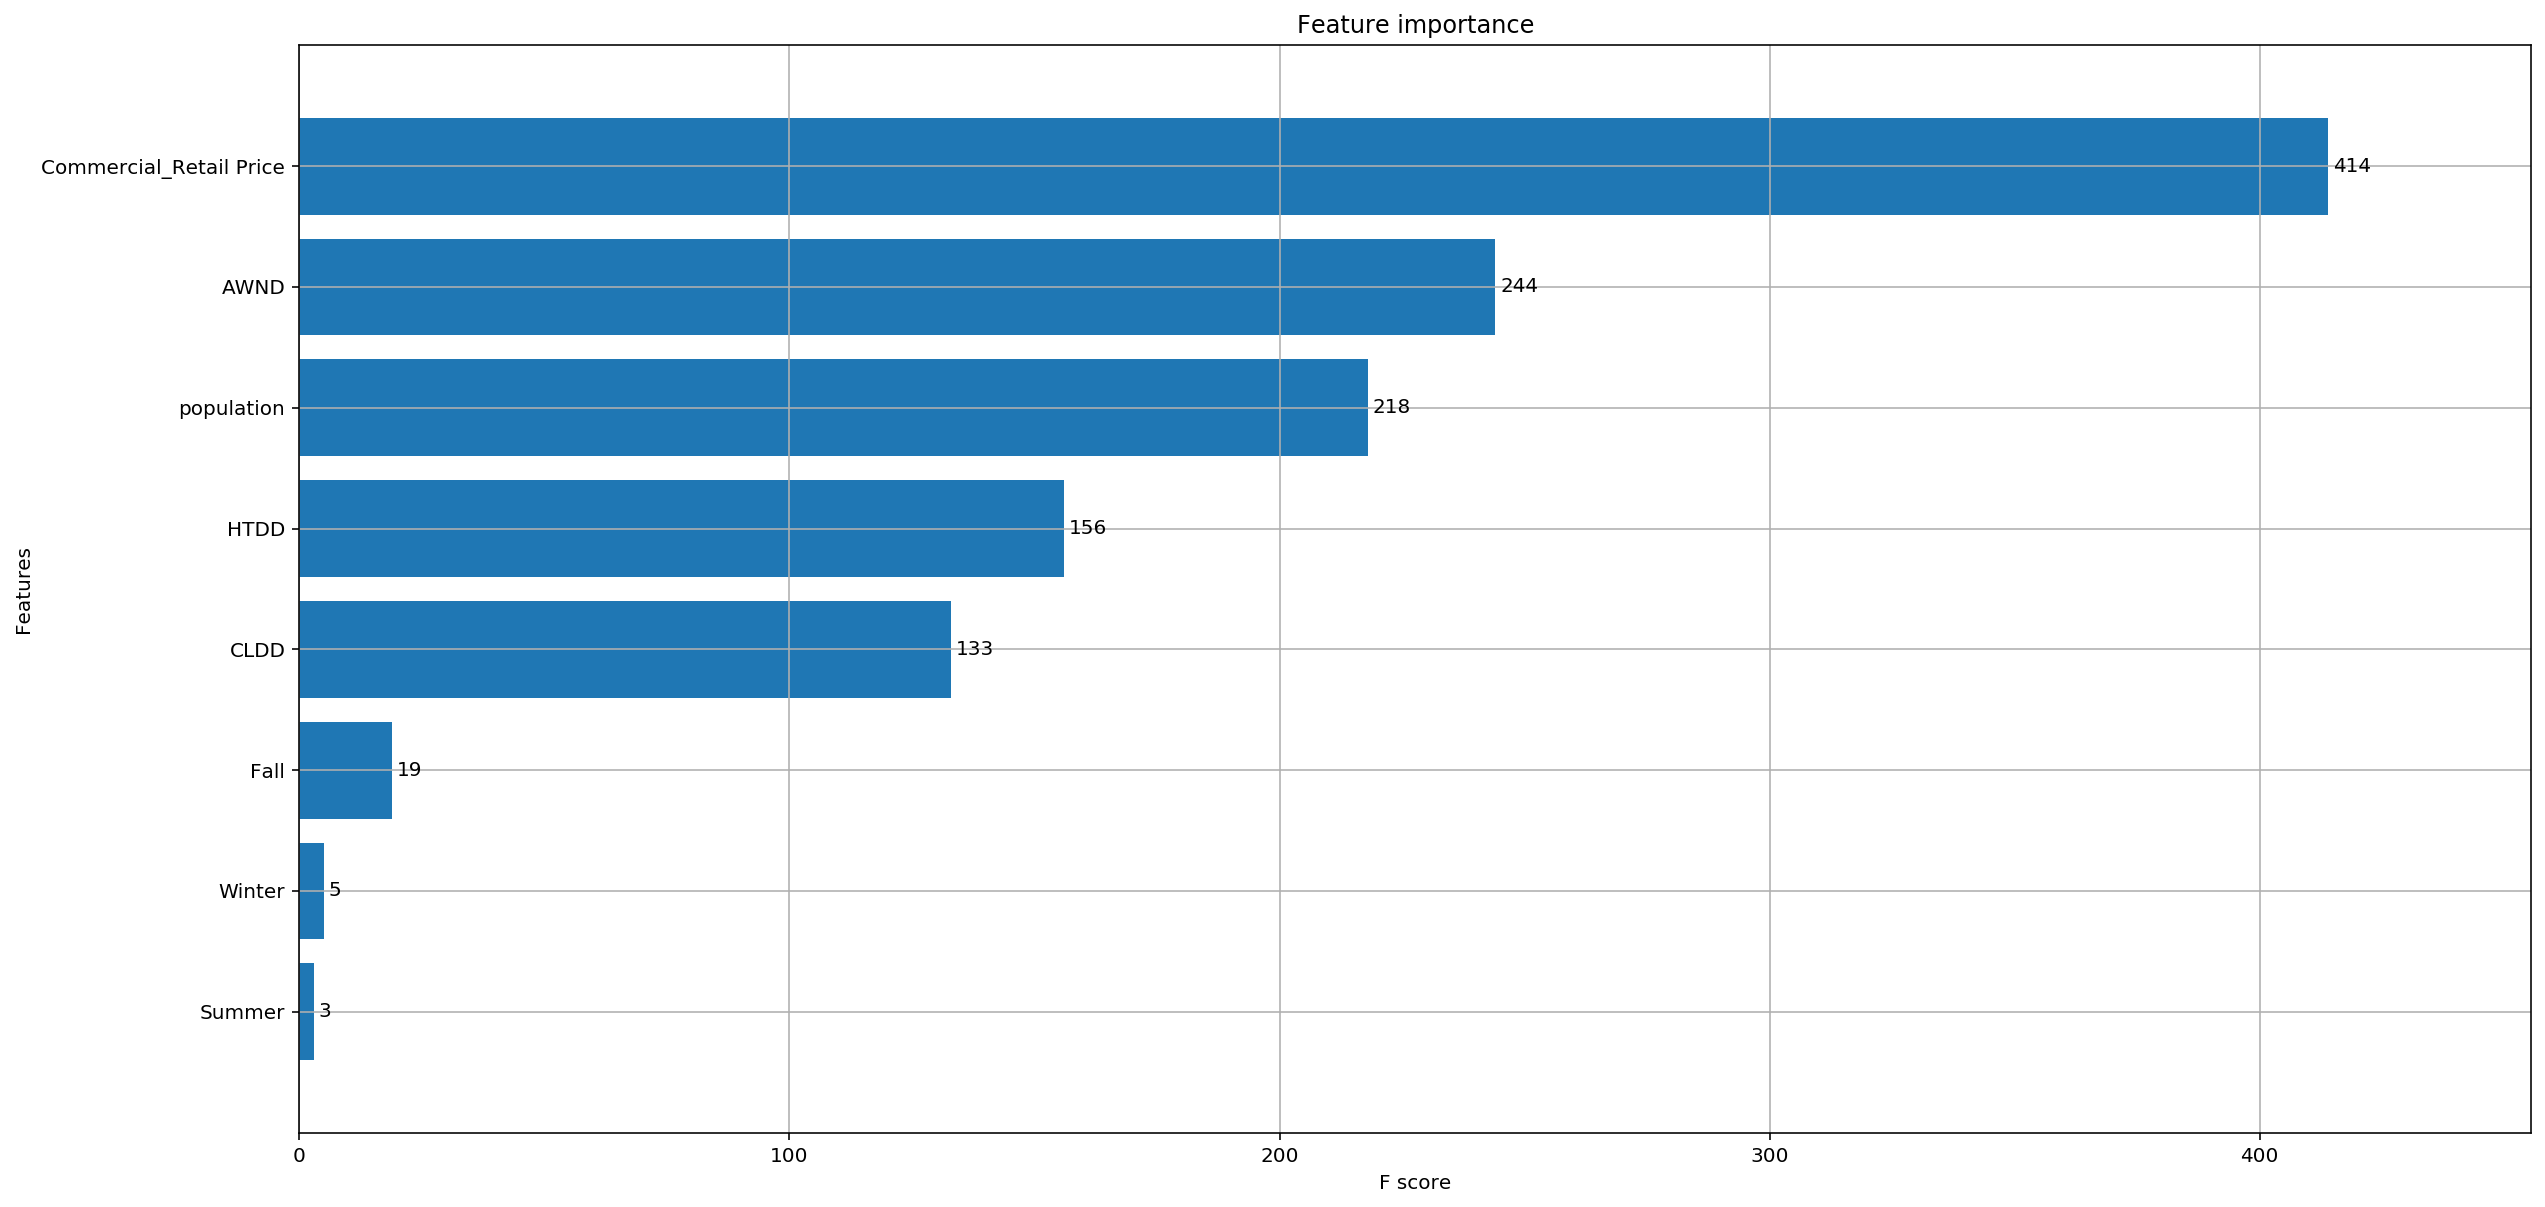

In [25]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

### Commercial_Regression_Visualizations

In [26]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [27]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [28]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


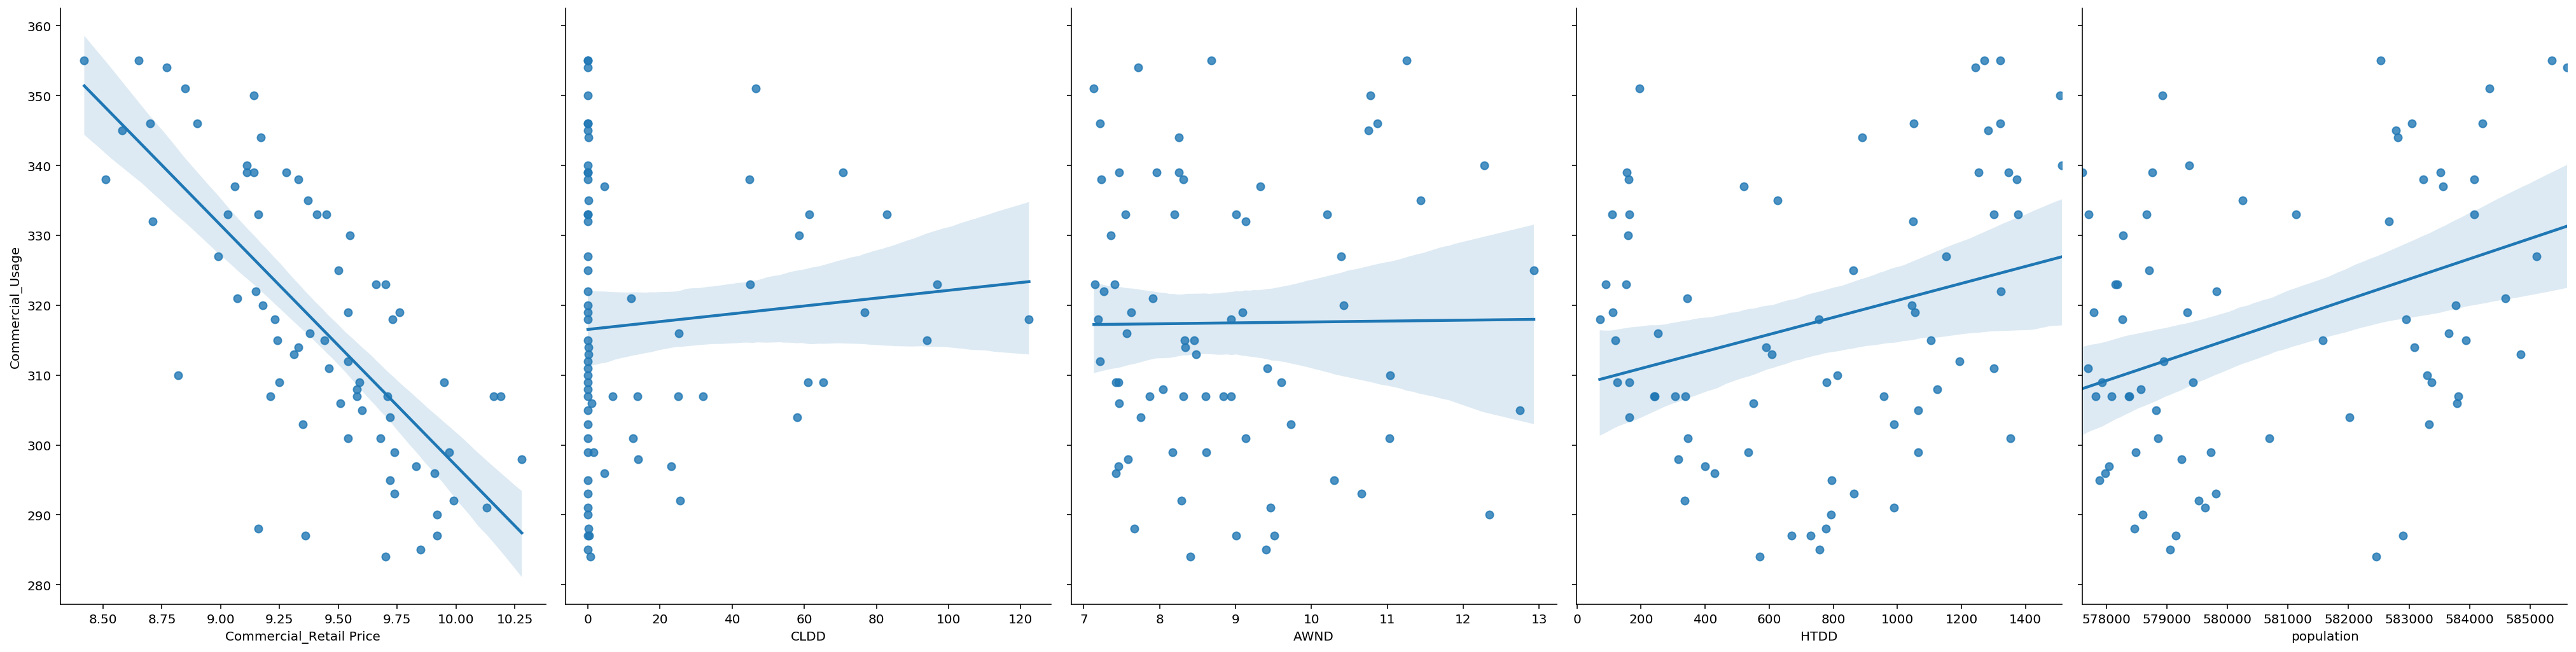

In [29]:
# Correlation Analysis
correlation_analysis(data_WY, commercial_numeric_columns_adj, ['Commercial_Usage'])

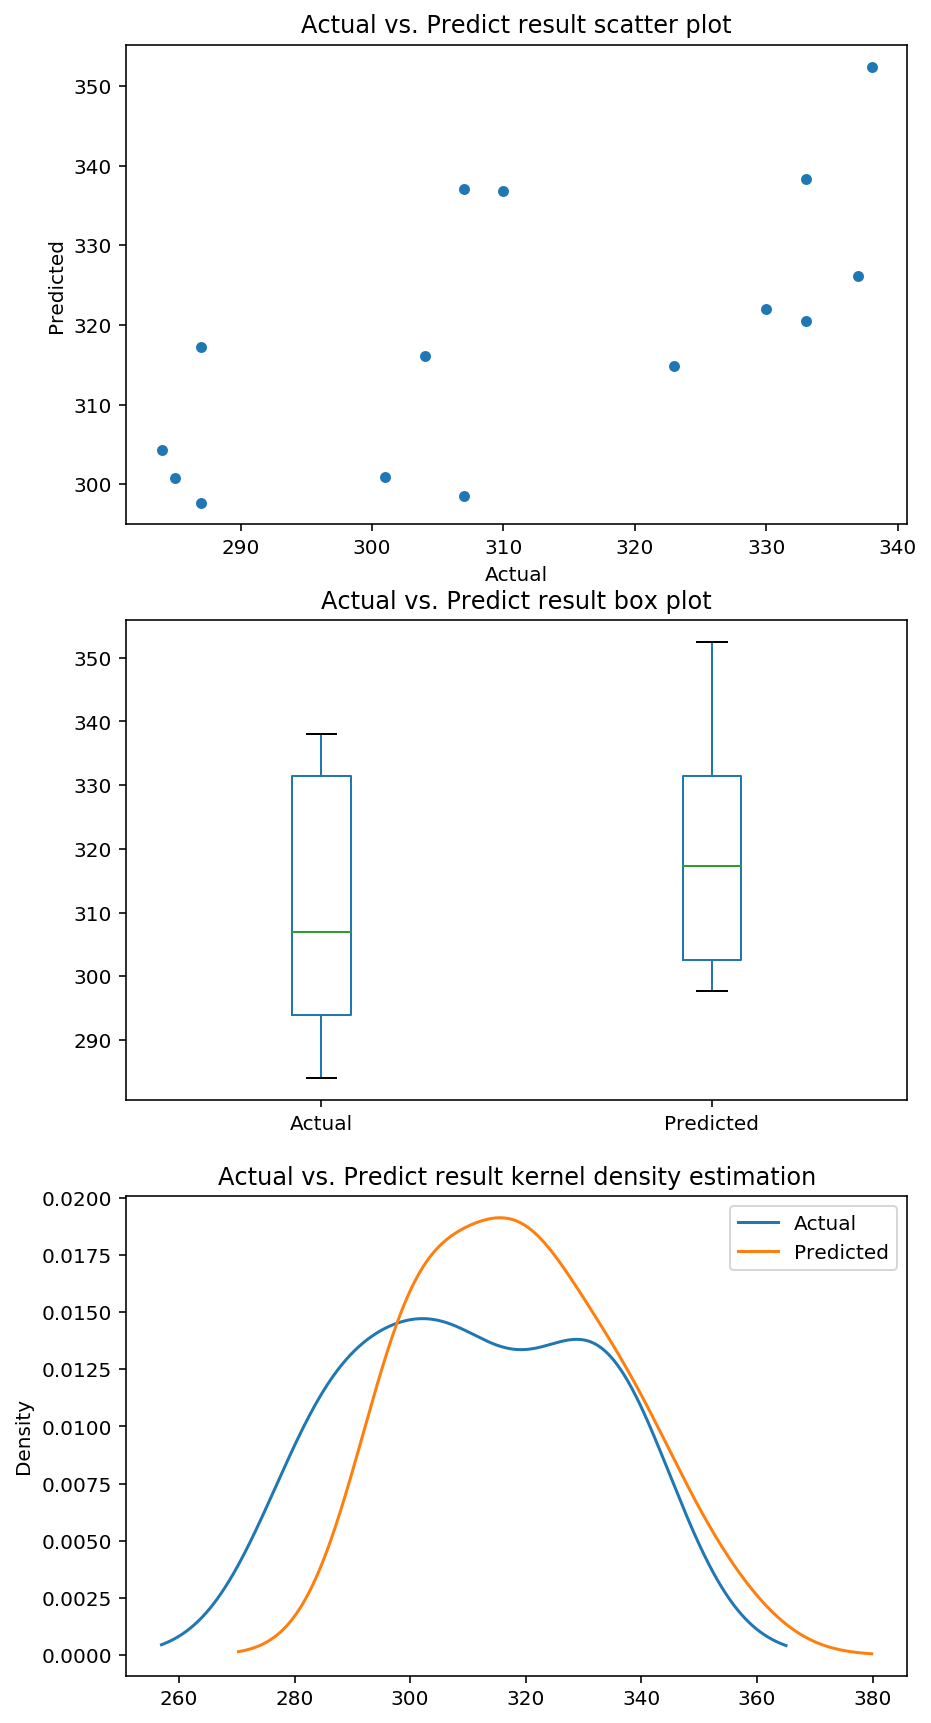

In [30]:
# Visualize Output
visualize_graph(df_pred_c)

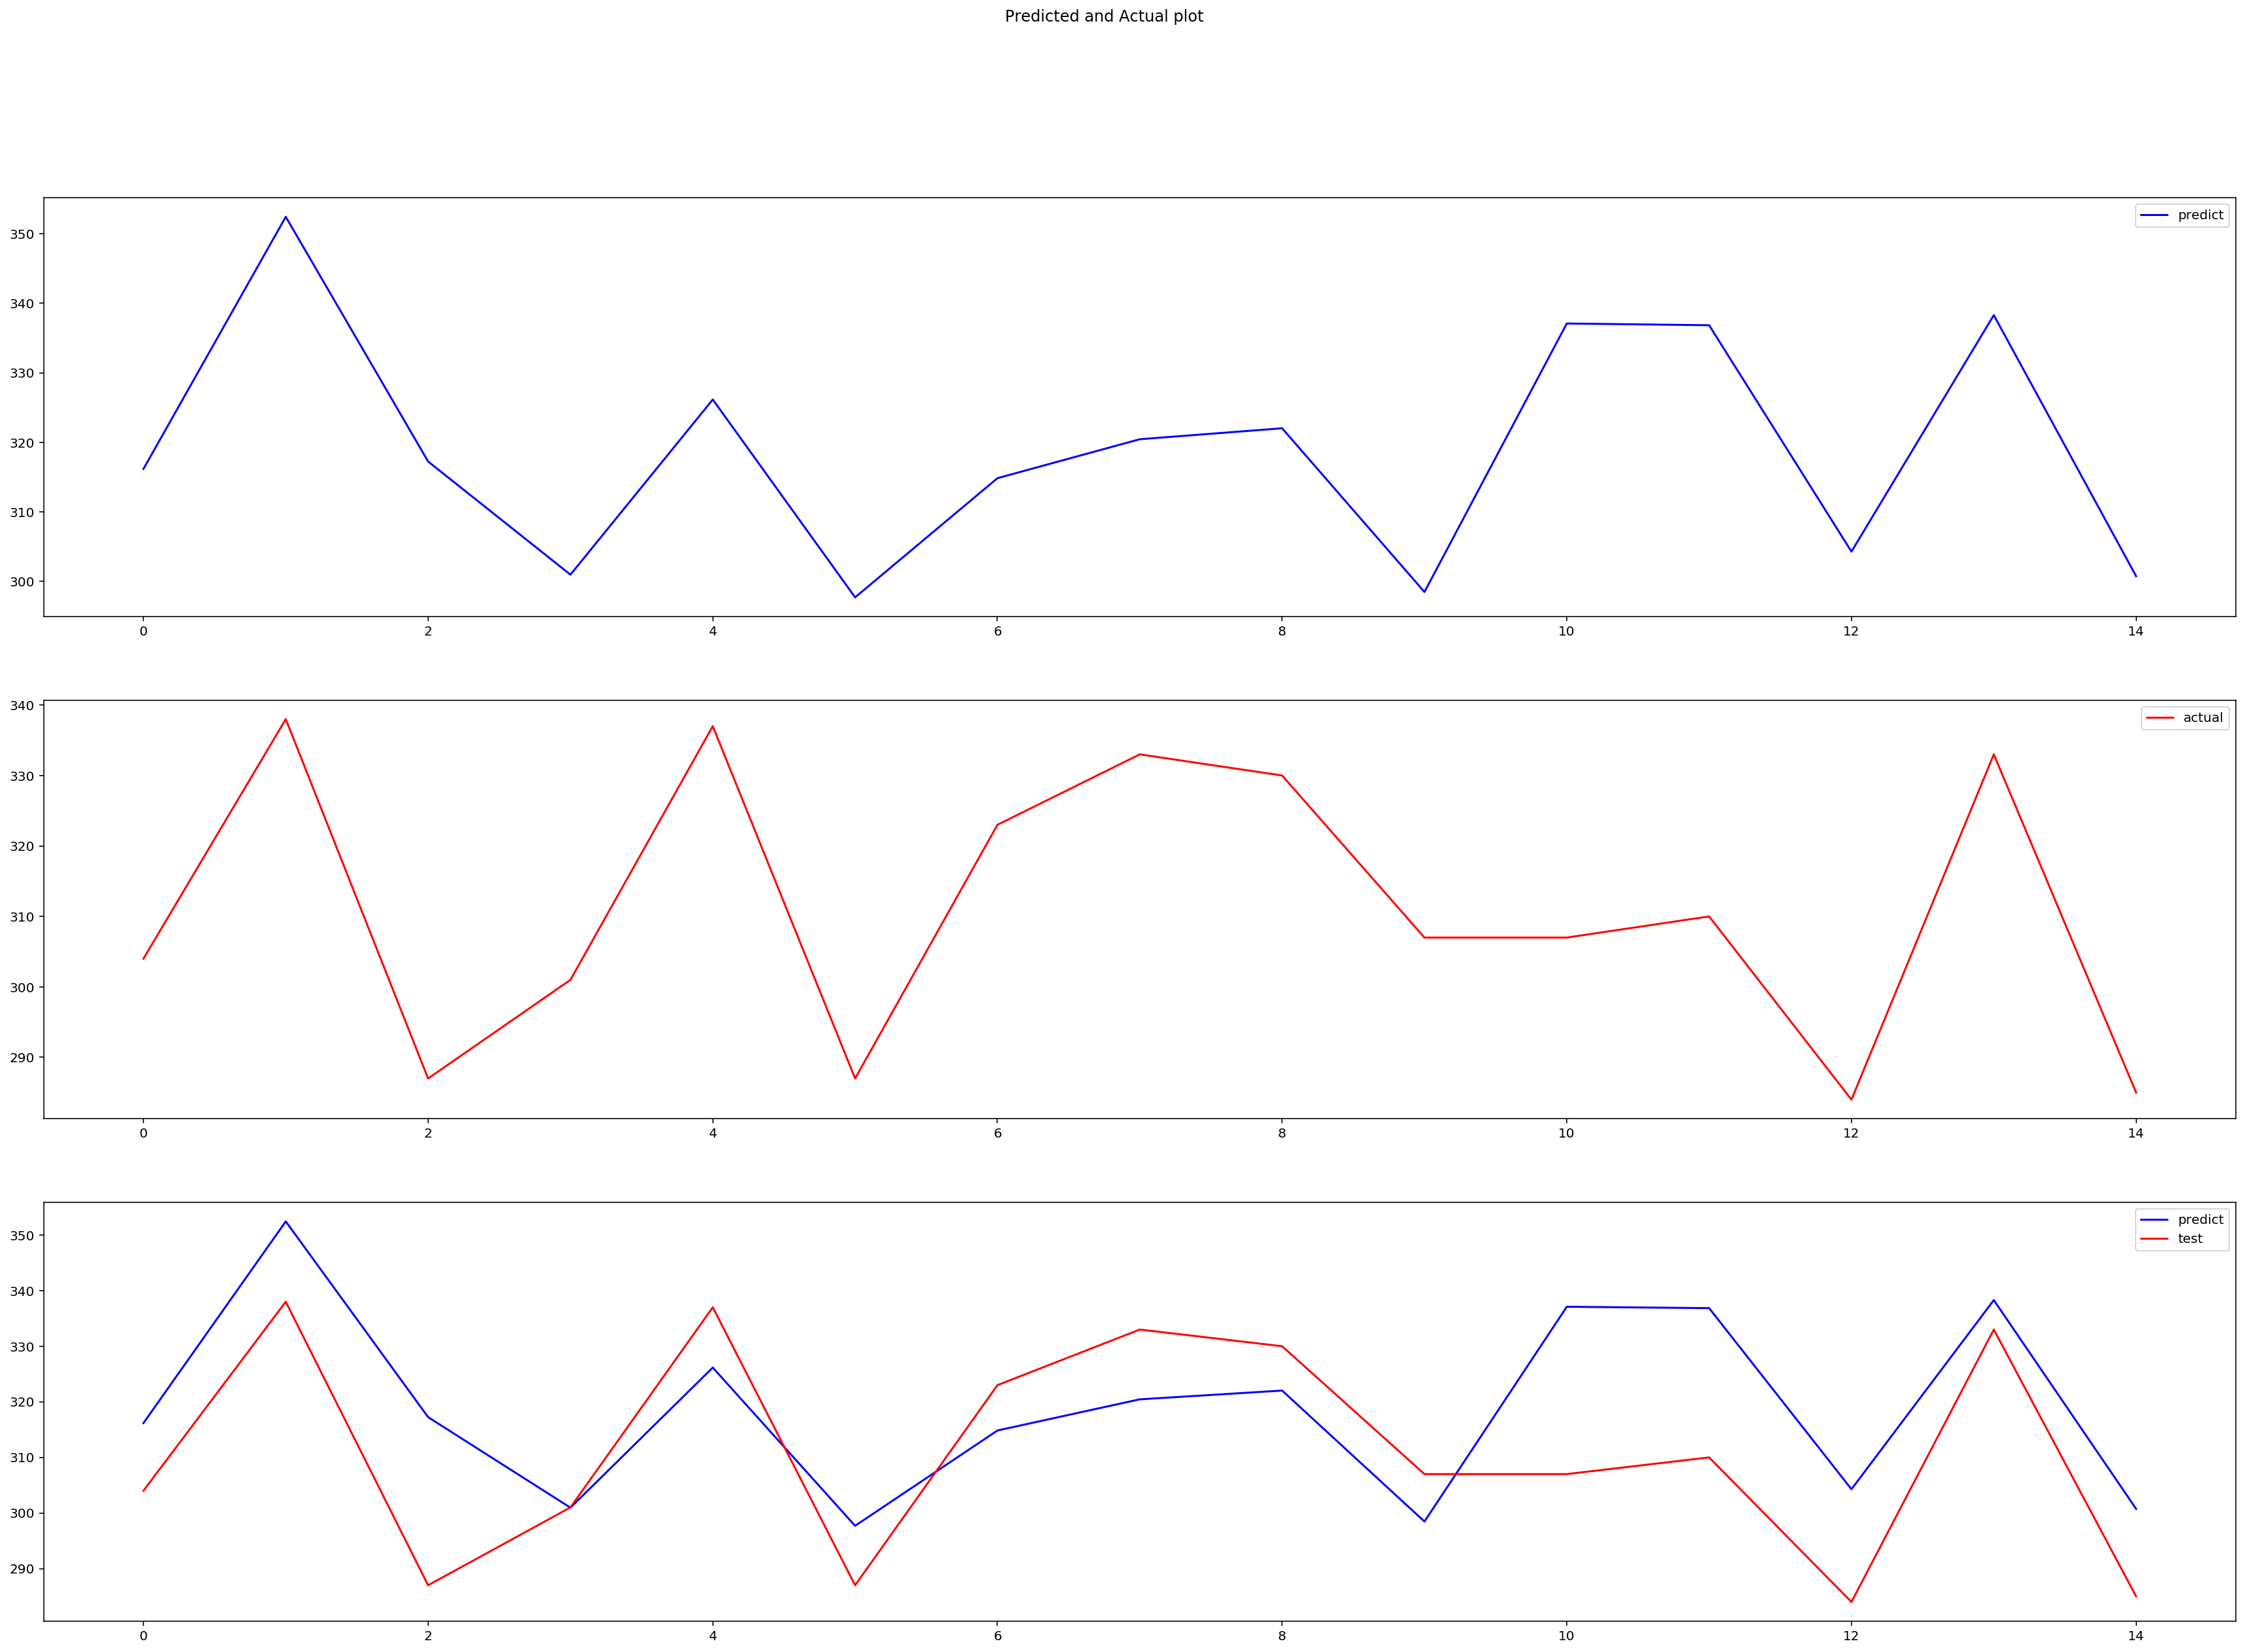

In [31]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

### Commercial_ANN

In [32]:
features_ANN_c=['Month', 'Commercial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Commercial_Retail Price']
#Spring is the seasonal feature baseline
data_WY_ANN=data[data.WY==1]
data_WY_ANN=data_WY_ANN[features_ANN_c]
data_WY_ANN

,Month,Commercial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Commercial_Retail Price
49,1,355,0.000000,11.258333,1320.406393,582531,0,0,0,1,8.42
99,2,345,0.000000,10.750000,1283.599078,582788,0,0,0,1,8.58
149,3,346,0.000000,10.866667,1051.477064,583045,0,0,0,0,8.70
199,4,310,0.000000,11.033333,813.004546,583302,0,0,0,0,8.82
249,5,337,4.495495,9.325000,519.815315,583558,0,0,0,0,9.06
...,...,...,...,...,...,...,...,...,...,...,...
3399,8,309,65.274775,7.426316,126.036036,579435,0,1,0,0,9.59
3449,9,292,25.626728,8.283333,337.004608,579531,0,0,1,0,9.99
3499,10,291,0.000000,9.463158,989.926605,579628,0,0,1,0,10.13
3549,11,299,0.000000,8.168421,1064.133641,579724,0,0,1,0,9.74


In [33]:
train_ANN, test_ANN = train_test_split(data_WY_ANN, test_size=0.2)
X_train_ANN_c, y_train_ANN_c = x_y_split(train_ANN, 'Commercial_Usage', ['Commercial_Usage'])
X_test_ANN_c,y_test_ANN_c = x_y_split(test_ANN, 'Commercial_Usage', ['Commercial_Usage'])

In [34]:
X_train_ANN_c, X_test_ANN_c = minmax_scaler(X_train_ANN_c, X_test_ANN_c, commercial_numeric_columns_adj)
y_train_ANN_c = (y_train_ANN_c - min(y_train_ANN_c))/(max(y_train_ANN_c) - min(y_train_ANN_c))

In [35]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_c, y_train_ANN_c, validation_split = 0.2, batch_size = 10, epochs = 1000)

Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 0.0736 - mae: 0.2383 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0736 - mae: 0.2382 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0735 - mae: 0.2380 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0735 - mae: 0.2380 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0735 - mae: 0.2378 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0734 - mae: 0.2377 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0734 - mae: 0.2376 - val_loss: 0.0638 - val_mae: 0.1819
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0733 - ma

Epoch 63/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0573 - mae: 0.2009 - val_loss: 0.0566 - val_mae: 0.1842
Epoch 64/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0569 - mae: 0.2001 - val_loss: 0.0565 - val_mae: 0.1842
Epoch 65/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0565 - mae: 0.1993 - val_loss: 0.0564 - val_mae: 0.1840
Epoch 66/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0561 - mae: 0.1983 - val_loss: 0.0563 - val_mae: 0.1840
Epoch 67/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0557 - mae: 0.1973 - val_loss: 0.0562 - val_mae: 0.1842
Epoch 68/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0553 - mae: 0.1965 - val_loss: 0.0562 - val_mae: 0.1851
Epoch 69/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0550 - mae: 0.1953 - val_loss: 0.0561 - val_mae: 0.1855
Epoch 70/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.05

5/5 [==============================] - 0s 10ms/step - loss: 0.0421 - mae: 0.1688 - val_loss: 0.0510 - val_mae: 0.1719
Epoch 126/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0421 - mae: 0.1685 - val_loss: 0.0509 - val_mae: 0.1716
Epoch 127/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0420 - mae: 0.1686 - val_loss: 0.0511 - val_mae: 0.1714
Epoch 128/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0419 - mae: 0.1683 - val_loss: 0.0508 - val_mae: 0.1712
Epoch 129/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0418 - mae: 0.1678 - val_loss: 0.0506 - val_mae: 0.1709
Epoch 130/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0416 - mae: 0.1673 - val_loss: 0.0505 - val_mae: 0.1709
Epoch 131/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0415 - mae: 0.1673 - val_loss: 0.0507 - val_mae: 0.1708
Epoch 132/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0413 - mae

5/5 [==============================] - 0s 10ms/step - loss: 0.0366 - mae: 0.1566 - val_loss: 0.0465 - val_mae: 0.1675
Epoch 187/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0366 - mae: 0.1572 - val_loss: 0.0468 - val_mae: 0.1686
Epoch 188/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0367 - mae: 0.1578 - val_loss: 0.0468 - val_mae: 0.1693
Epoch 189/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0365 - mae: 0.1578 - val_loss: 0.0478 - val_mae: 0.1726
Epoch 190/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0366 - mae: 0.1588 - val_loss: 0.0476 - val_mae: 0.1726
Epoch 191/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0364 - mae: 0.1583 - val_loss: 0.0470 - val_mae: 0.1714
Epoch 192/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0363 - mae: 0.1568 - val_loss: 0.0460 - val_mae: 0.1693
Epoch 193/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0362 - mae:

5/5 [==============================] - 0s 9ms/step - loss: 0.0333 - mae: 0.1466 - val_loss: 0.0420 - val_mae: 0.1612
Epoch 248/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0332 - mae: 0.1466 - val_loss: 0.0417 - val_mae: 0.1605
Epoch 249/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0331 - mae: 0.1460 - val_loss: 0.0409 - val_mae: 0.1585
Epoch 250/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0330 - mae: 0.1451 - val_loss: 0.0409 - val_mae: 0.1587
Epoch 251/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0330 - mae: 0.1450 - val_loss: 0.0408 - val_mae: 0.1588
Epoch 252/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0329 - mae: 0.1456 - val_loss: 0.0414 - val_mae: 0.1607
Epoch 253/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0329 - mae: 0.1460 - val_loss: 0.0418 - val_mae: 0.1617
Epoch 254/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0329 - ma

Epoch 309/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0306 - mae: 0.1383 - val_loss: 0.0374 - val_mae: 0.1538
Epoch 310/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0307 - mae: 0.1387 - val_loss: 0.0380 - val_mae: 0.1554
Epoch 311/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0307 - mae: 0.1387 - val_loss: 0.0368 - val_mae: 0.1525
Epoch 312/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0305 - mae: 0.1371 - val_loss: 0.0365 - val_mae: 0.1517
Epoch 313/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0305 - mae: 0.1369 - val_loss: 0.0360 - val_mae: 0.1501
Epoch 314/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0304 - mae: 0.1366 - val_loss: 0.0356 - val_mae: 0.1494
Epoch 315/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0305 - mae: 0.1368 - val_loss: 0.0354 - val_mae: 0.1488
Epoch 316/1000
5/5 [==============================] - 0s 8ms/step - los

Epoch 371/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0287 - mae: 0.1316 - val_loss: 0.0332 - val_mae: 0.1444
Epoch 372/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0287 - mae: 0.1312 - val_loss: 0.0324 - val_mae: 0.1425
Epoch 373/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0286 - mae: 0.1308 - val_loss: 0.0321 - val_mae: 0.1423
Epoch 374/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0287 - mae: 0.1315 - val_loss: 0.0324 - val_mae: 0.1427
Epoch 375/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0287 - mae: 0.1311 - val_loss: 0.0326 - val_mae: 0.1434
Epoch 376/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0285 - mae: 0.1309 - val_loss: 0.0324 - val_mae: 0.1432
Epoch 377/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0286 - mae: 0.1309 - val_loss: 0.0323 - val_mae: 0.1434
Epoch 378/1000
5/5 [==============================] - 0s 8ms/step - loss:

Epoch 433/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0273 - mae: 0.1283 - val_loss: 0.0294 - val_mae: 0.1409
Epoch 434/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0272 - mae: 0.1279 - val_loss: 0.0298 - val_mae: 0.1413
Epoch 435/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0272 - mae: 0.1279 - val_loss: 0.0298 - val_mae: 0.1413
Epoch 436/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0271 - mae: 0.1275 - val_loss: 0.0294 - val_mae: 0.1408
Epoch 437/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0271 - mae: 0.1276 - val_loss: 0.0292 - val_mae: 0.1406
Epoch 438/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0272 - mae: 0.1274 - val_loss: 0.0295 - val_mae: 0.1410
Epoch 439/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0271 - mae: 0.1274 - val_loss: 0.0294 - val_mae: 0.1408
Epoch 440/1000
5/5 [==============================] - 0s 10ms/step - l

Epoch 495/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0262 - mae: 0.1250 - val_loss: 0.0287 - val_mae: 0.1394
Epoch 496/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0262 - mae: 0.1247 - val_loss: 0.0291 - val_mae: 0.1394
Epoch 497/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0262 - mae: 0.1248 - val_loss: 0.0287 - val_mae: 0.1389
Epoch 498/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0262 - mae: 0.1248 - val_loss: 0.0279 - val_mae: 0.1379
Epoch 499/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0262 - mae: 0.1247 - val_loss: 0.0284 - val_mae: 0.1382
Epoch 500/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0261 - mae: 0.1246 - val_loss: 0.0287 - val_mae: 0.1381
Epoch 501/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0261 - mae: 0.1245 - val_loss: 0.0280 - val_mae: 0.1375
Epoch 502/1000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 0.0250 - mae: 0.1223 - val_loss: 0.0269 - val_mae: 0.1351
Epoch 557/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0252 - mae: 0.1226 - val_loss: 0.0266 - val_mae: 0.1344
Epoch 558/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0250 - mae: 0.1223 - val_loss: 0.0269 - val_mae: 0.1357
Epoch 559/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0251 - mae: 0.1225 - val_loss: 0.0276 - val_mae: 0.1379
Epoch 560/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0249 - mae: 0.1218 - val_loss: 0.0269 - val_mae: 0.1356
Epoch 561/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0250 - mae: 0.1224 - val_loss: 0.0272 - val_mae: 0.1366
Epoch 562/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0249 - mae: 0.1218 - val_loss: 0.0271 - val_mae: 0.1366
Epoch 563/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0250 - mae:

Epoch 618/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0244 - mae: 0.1199 - val_loss: 0.0305 - val_mae: 0.1446
Epoch 619/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0244 - mae: 0.1196 - val_loss: 0.0301 - val_mae: 0.1432
Epoch 620/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0242 - mae: 0.1188 - val_loss: 0.0281 - val_mae: 0.1383
Epoch 621/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0245 - mae: 0.1201 - val_loss: 0.0279 - val_mae: 0.1371
Epoch 622/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0243 - mae: 0.1200 - val_loss: 0.0299 - val_mae: 0.1427
Epoch 623/1000
5/5 [==============================] - ETA: 0s - loss: 0.0181 - mae: 0.098 - 0s 8ms/step - loss: 0.0244 - mae: 0.1195 - val_loss: 0.0307 - val_mae: 0.1451
Epoch 624/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0243 - mae: 0.1191 - val_loss: 0.0300 - val_mae: 0.1430
Epoch 625/1000
5/5 [==============

5/5 [==============================] - 0s 10ms/step - loss: 0.0240 - mae: 0.1183 - val_loss: 0.0290 - val_mae: 0.1412
Epoch 680/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0239 - mae: 0.1185 - val_loss: 0.0299 - val_mae: 0.1444
Epoch 681/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0240 - mae: 0.1184 - val_loss: 0.0312 - val_mae: 0.1482
Epoch 682/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0240 - mae: 0.1185 - val_loss: 0.0307 - val_mae: 0.1467
Epoch 683/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0239 - mae: 0.1184 - val_loss: 0.0304 - val_mae: 0.1460
Epoch 684/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0241 - mae: 0.1191 - val_loss: 0.0296 - val_mae: 0.1434
Epoch 685/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0238 - mae: 0.1187 - val_loss: 0.0310 - val_mae: 0.1480
Epoch 686/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0239 - mae

Epoch 741/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0236 - mae: 0.1172 - val_loss: 0.0335 - val_mae: 0.1538
Epoch 742/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0236 - mae: 0.1173 - val_loss: 0.0337 - val_mae: 0.1543
Epoch 743/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0236 - mae: 0.1174 - val_loss: 0.0340 - val_mae: 0.1550
Epoch 744/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0236 - mae: 0.1166 - val_loss: 0.0364 - val_mae: 0.1606
Epoch 745/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0237 - mae: 0.1172 - val_loss: 0.0358 - val_mae: 0.1593
Epoch 746/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0237 - mae: 0.1173 - val_loss: 0.0349 - val_mae: 0.1574
Epoch 747/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0236 - mae: 0.1173 - val_loss: 0.0327 - val_mae: 0.1515
Epoch 748/1000
5/5 [==============================] - 0s 10ms/step - los

5/5 [==============================] - 0s 10ms/step - loss: 0.0233 - mae: 0.1165 - val_loss: 0.0373 - val_mae: 0.1632
Epoch 803/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0234 - mae: 0.1165 - val_loss: 0.0378 - val_mae: 0.1646
Epoch 804/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0233 - mae: 0.1161 - val_loss: 0.0375 - val_mae: 0.1637
Epoch 805/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0234 - mae: 0.1162 - val_loss: 0.0376 - val_mae: 0.1639
Epoch 806/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0233 - mae: 0.1164 - val_loss: 0.0365 - val_mae: 0.1599
Epoch 807/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0235 - mae: 0.1174 - val_loss: 0.0364 - val_mae: 0.1593
Epoch 808/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0234 - mae: 0.1169 - val_loss: 0.0369 - val_mae: 0.1614
Epoch 809/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0233 - m

Epoch 864/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0231 - mae: 0.1151 - val_loss: 0.0324 - val_mae: 0.1524
Epoch 865/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0231 - mae: 0.1154 - val_loss: 0.0317 - val_mae: 0.1504
Epoch 866/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0234 - mae: 0.1172 - val_loss: 0.0309 - val_mae: 0.1478
Epoch 867/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0231 - mae: 0.1157 - val_loss: 0.0322 - val_mae: 0.1514
Epoch 868/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0231 - mae: 0.1160 - val_loss: 0.0329 - val_mae: 0.1532
Epoch 869/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0231 - mae: 0.1155 - val_loss: 0.0327 - val_mae: 0.1525
Epoch 870/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0231 - mae: 0.1152 - val_loss: 0.0319 - val_mae: 0.1506
Epoch 871/1000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.1147 - val_loss: 0.0300 - val_mae: 0.1445
Epoch 926/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0230 - mae: 0.1151 - val_loss: 0.0307 - val_mae: 0.1468
Epoch 927/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0229 - mae: 0.1144 - val_loss: 0.0324 - val_mae: 0.1522
Epoch 928/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.1146 - val_loss: 0.0320 - val_mae: 0.1510
Epoch 929/1000
5/5 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.068 - 0s 8ms/step - loss: 0.0229 - mae: 0.1144 - val_loss: 0.0313 - val_mae: 0.1491
Epoch 930/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0228 - mae: 0.1141 - val_loss: 0.0307 - val_mae: 0.1472
Epoch 931/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0230 - mae: 0.1155 - val_loss: 0.0295 - val_mae: 0.1435
Epoch 932/1000
5/5 [==============================]

5/5 [==============================] - 0s 10ms/step - loss: 0.0227 - mae: 0.1137 - val_loss: 0.0300 - val_mae: 0.1458
Epoch 987/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0226 - mae: 0.1134 - val_loss: 0.0310 - val_mae: 0.1495
Epoch 988/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0227 - mae: 0.1134 - val_loss: 0.0303 - val_mae: 0.1468
Epoch 989/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0227 - mae: 0.1135 - val_loss: 0.0301 - val_mae: 0.1460
Epoch 990/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0226 - mae: 0.1134 - val_loss: 0.0302 - val_mae: 0.1467
Epoch 991/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0228 - mae: 0.1138 - val_loss: 0.0310 - val_mae: 0.1501
Epoch 992/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0227 - mae: 0.1132 - val_loss: 0.0303 - val_mae: 0.1463
Epoch 993/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0227 - mae

In [36]:
# Predicting the Test set results
predictions_ANN_c = classifier.predict(X_test_ANN_c)
# Scale y back 
predictions_ANN_c = (predictions_ANN_c * (max(y_test_ANN_c) - min(y_test_ANN_c))) + min(y_test_ANN_c)
predictions_ANN_c = predictions_ANN_c.reshape(-1)
df_pred_ANN_c = pd.DataFrame({'Actual': y_test_ANN_c, 'Predicted': predictions_ANN_c})

In [37]:
df_pred_ANN_c

,Actual,Predicted
2049,299,294.596283
3249,287,294.853516
2949,308,313.913574
2449,339,319.585846
1749,293,312.692078
2899,288,330.649658
2149,318,334.238525
2849,307,302.606079
1549,315,334.238525
899,338,334.238525


In [38]:
evaluate_performances(y_test_ANN_c, predictions_ANN_c)

Performance Evaluation
Mean Absolute Error: 13.969024658203125
Mean Squared Error: 300.88047173017014
Root Mean Squared Error: 17.34590648338017


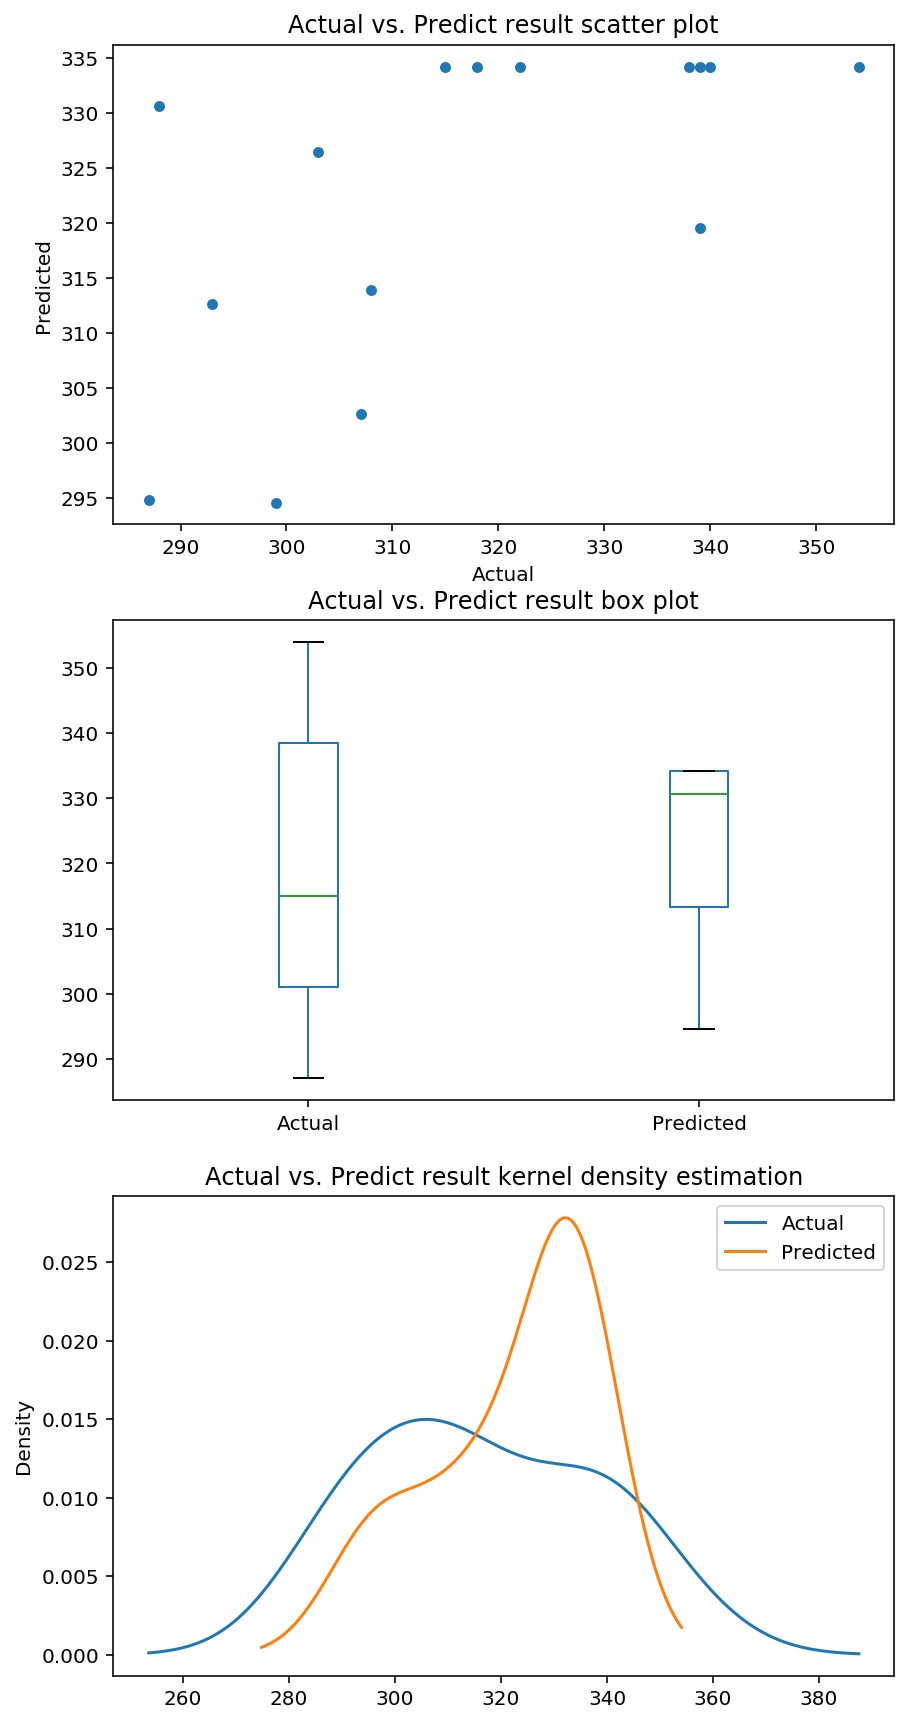

In [39]:
visualize_graph(df_pred_ANN_c)

## Industrial Consumption Forecast

In [40]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2.122
Date:                Tue, 21 Jul 2020   Prob (F-statistic):             0.0517
Time:                        16:30:57   Log-Likelihood:                -264.63
No. Observations:                  57   AIC:                             547.3
Df Residuals:                      48   BIC:                             565.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [41]:
df_pred_i

,Actual,Predicted
1499,835,848.079001
1199,860,876.322238
1399,798,839.271062
1649,838,842.014615
249,889,856.287732
3249,858,848.433035
2749,912,873.179805
2399,871,858.061342
2799,884,864.489145
2849,845,858.797455


In [42]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 29.157571127622123
Mean Squared Error: 1520.2074910686983
Root Mean Squared Error: 38.9898383052392


# Industrial Feature Importance

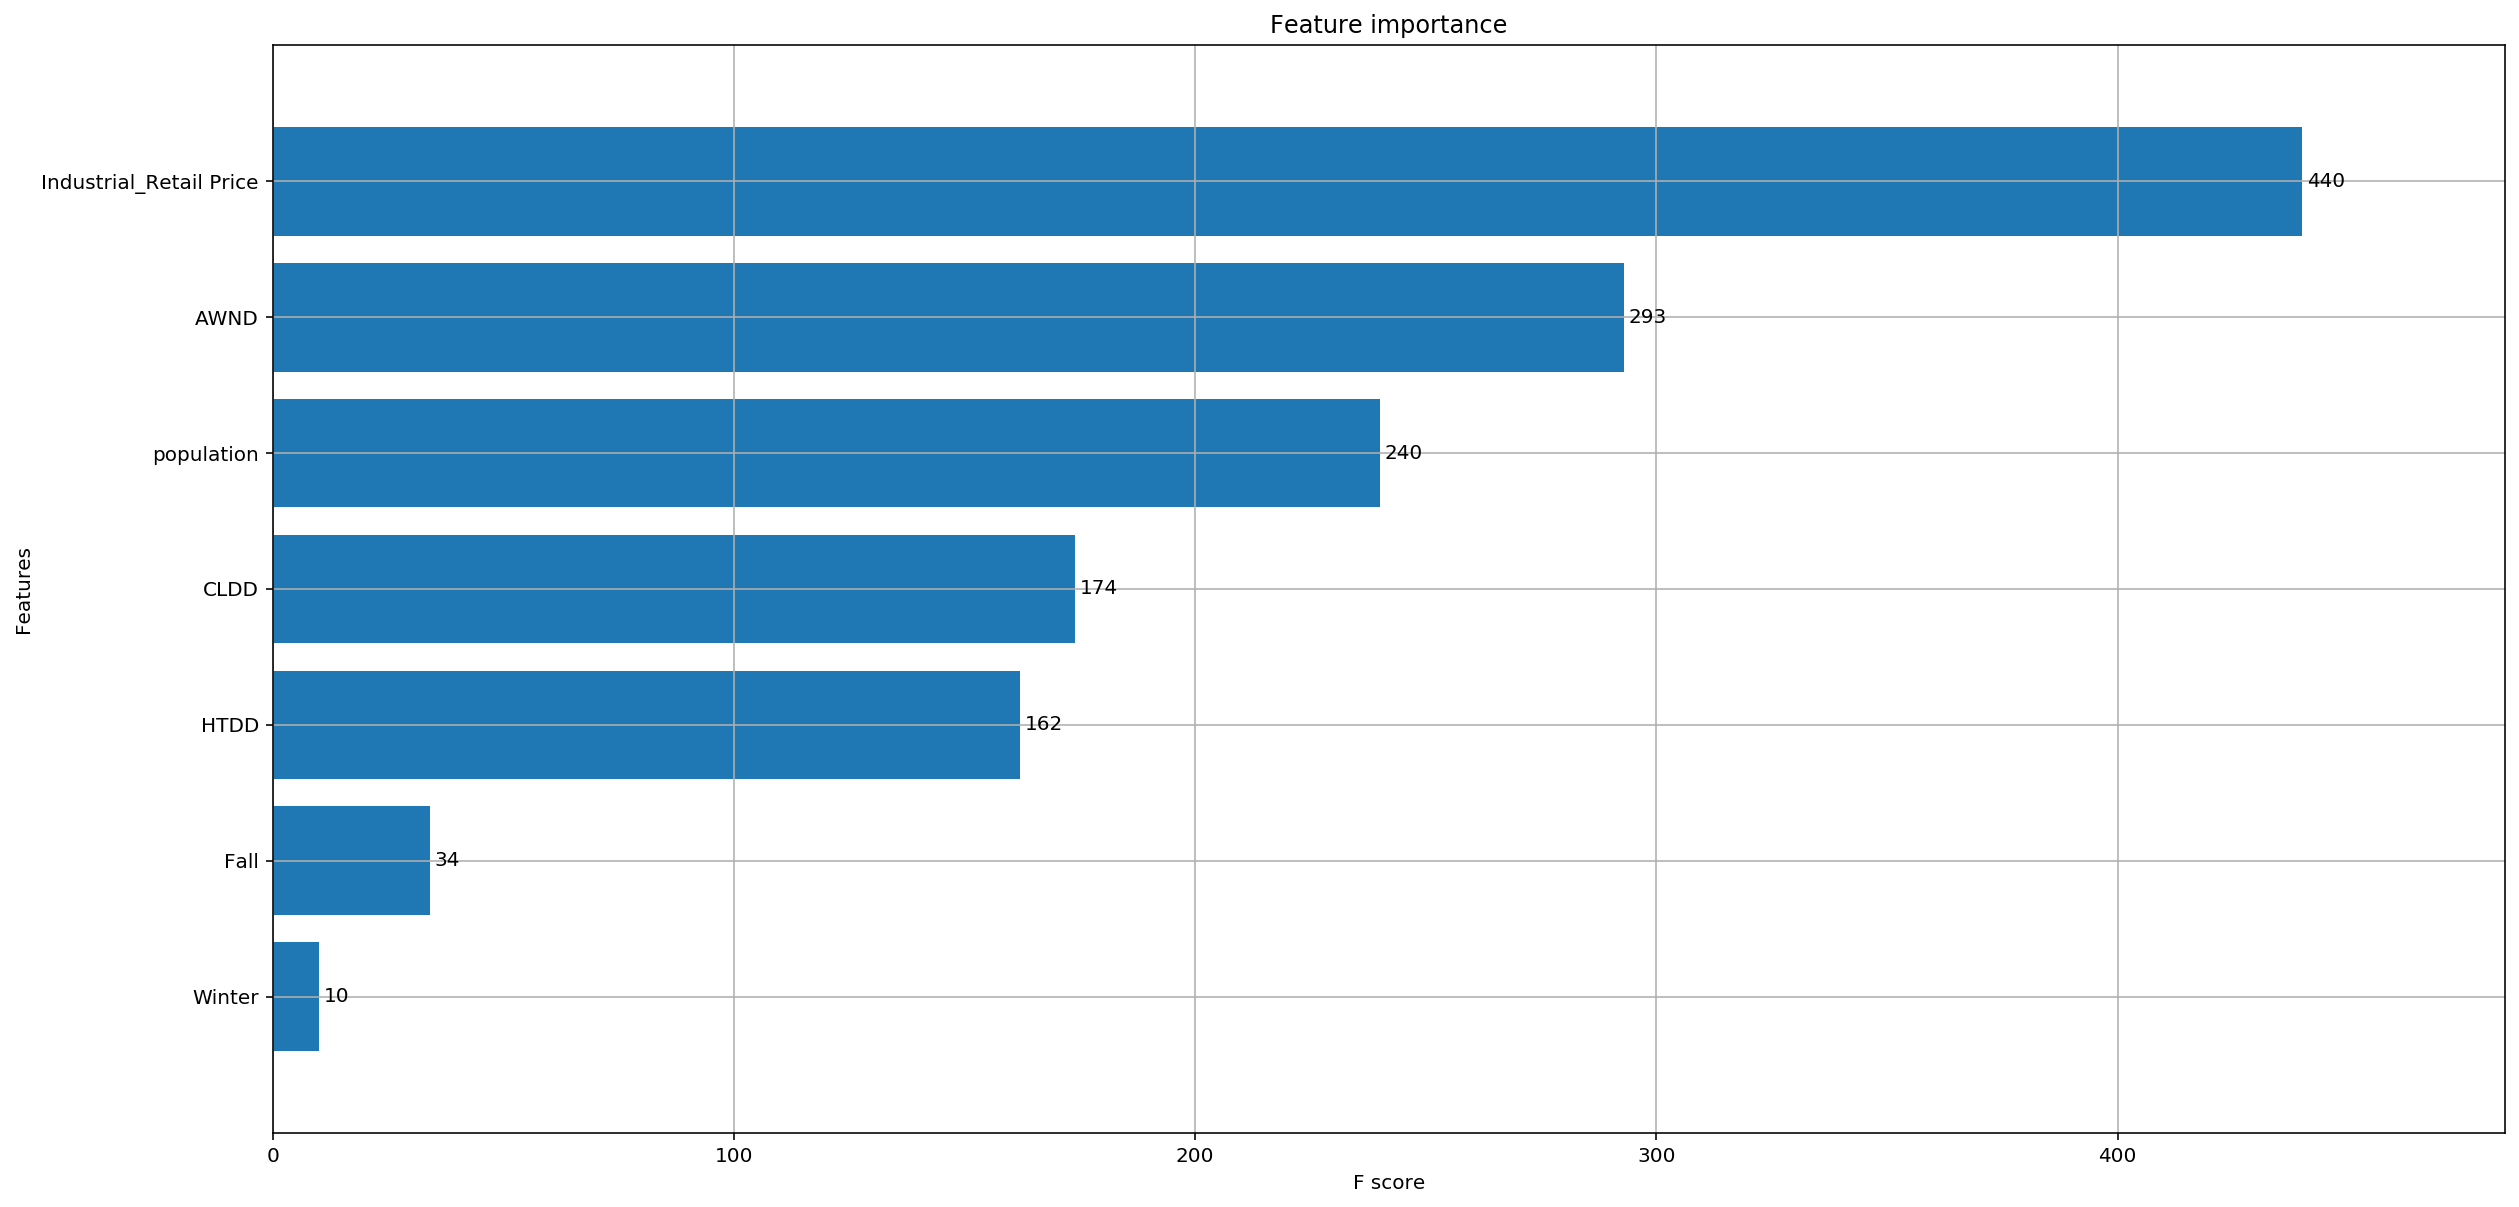

In [43]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


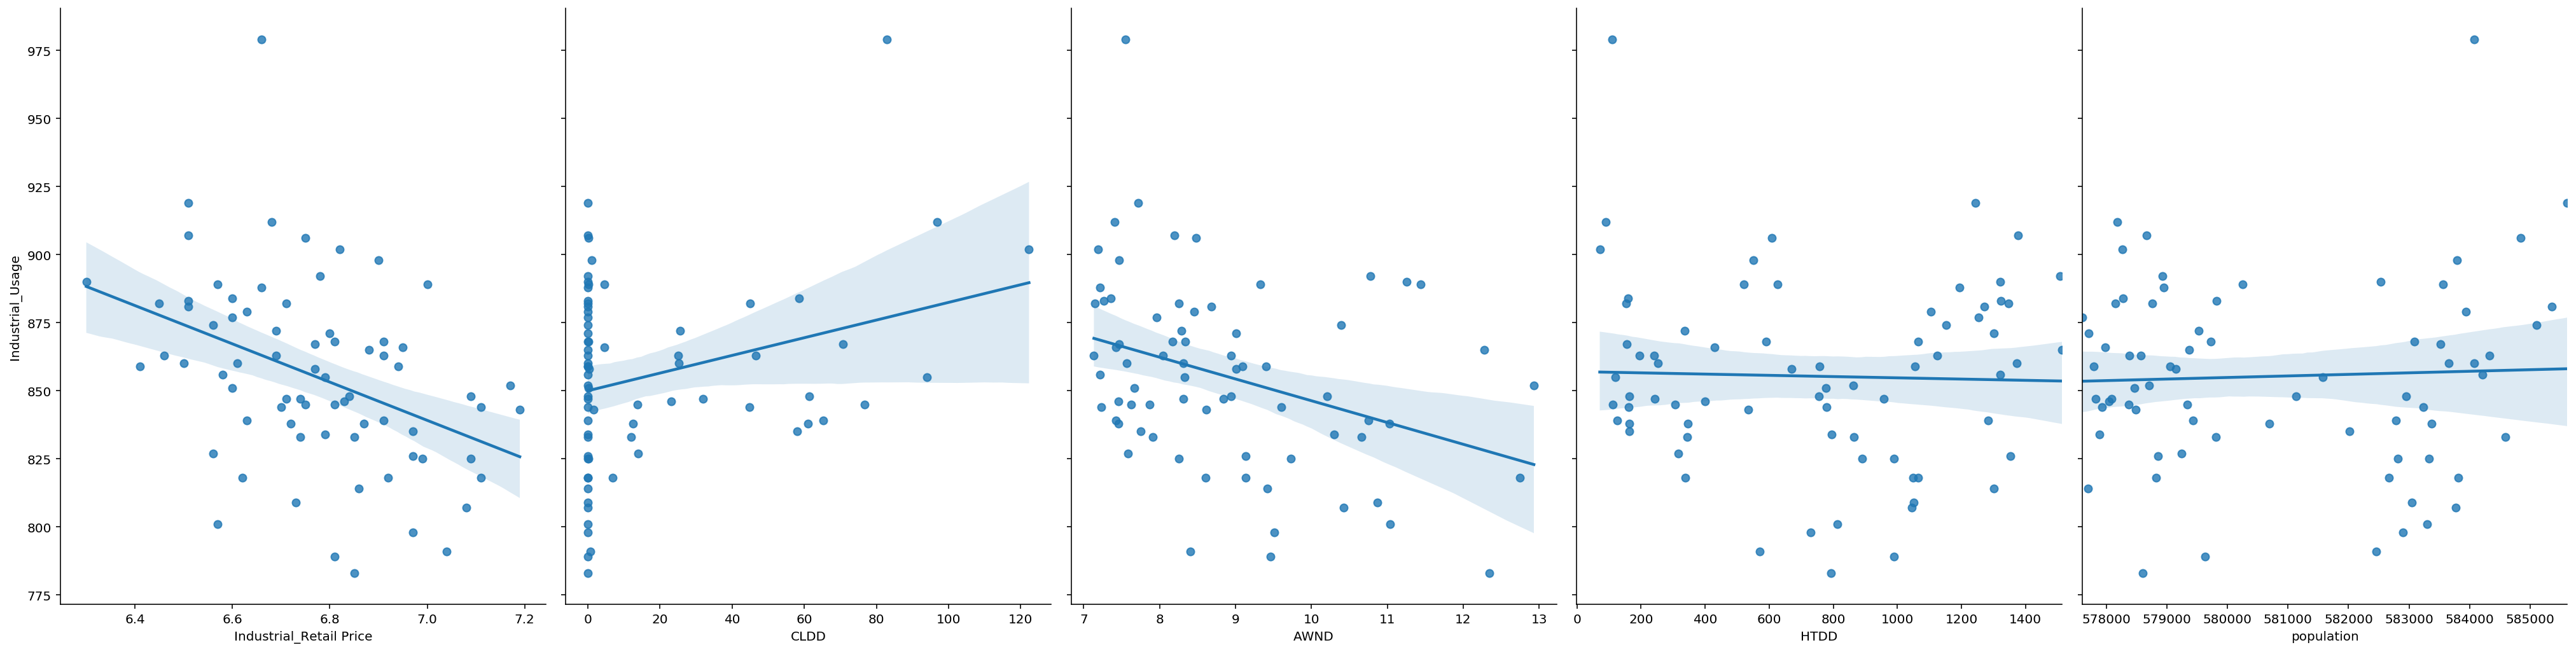

In [44]:
# Correlation Analysis
correlation_analysis(data_WY, industrial_numeric_columns_adj, ['Industrial_Usage'])

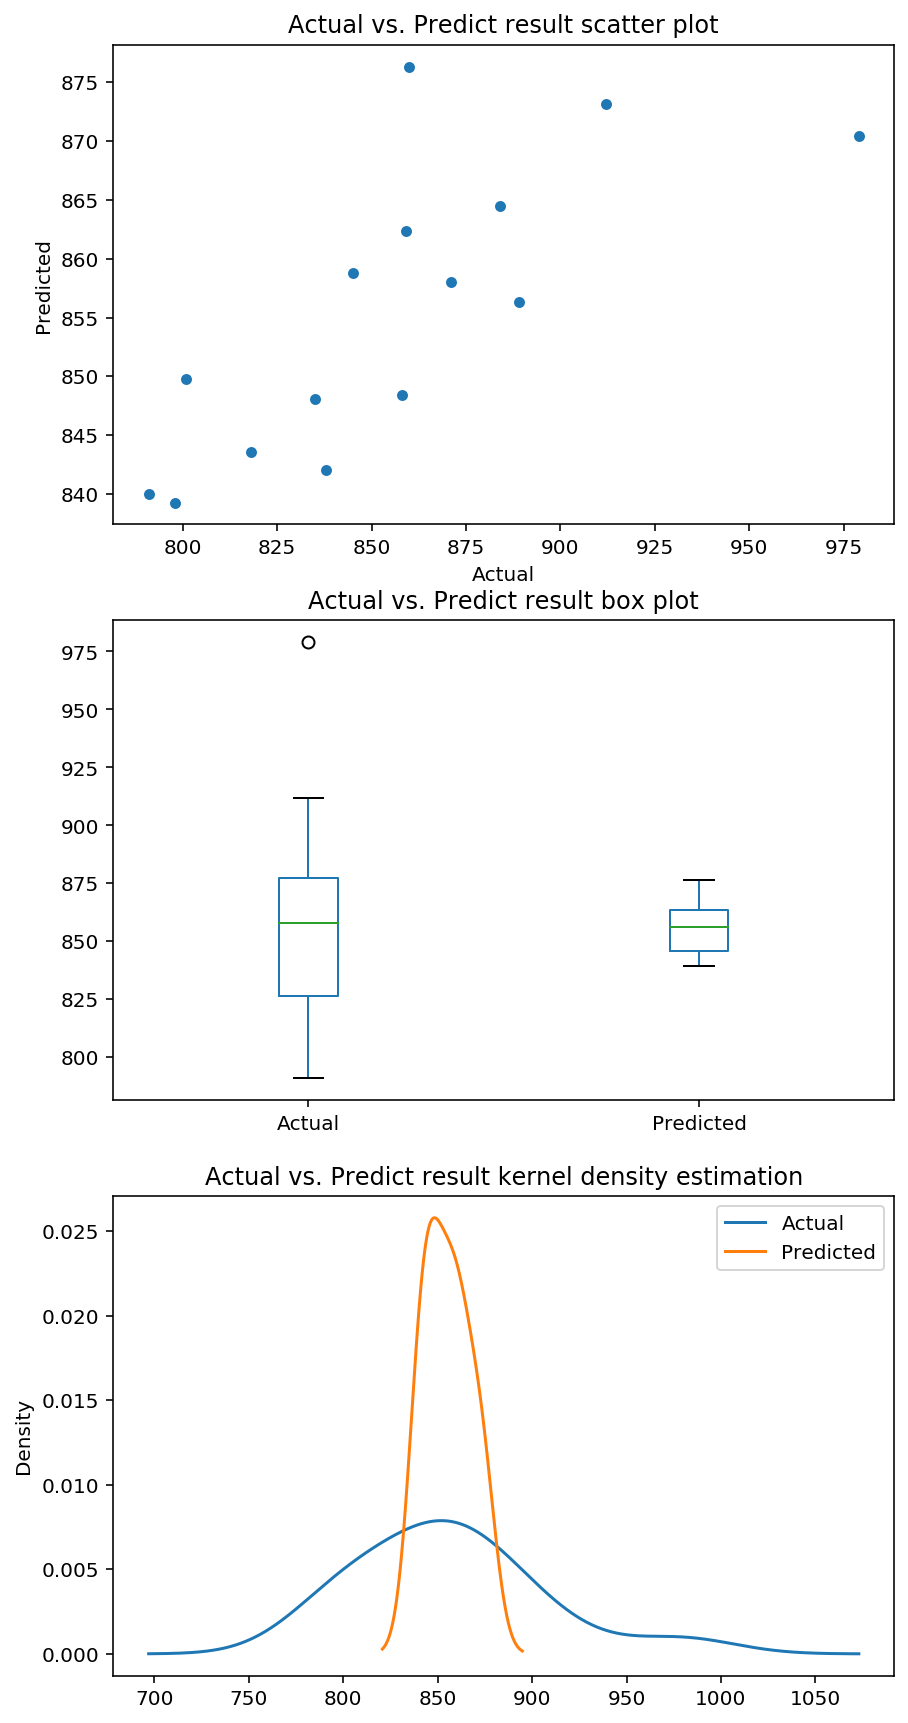

In [45]:
visualize_graph(df_pred_i)

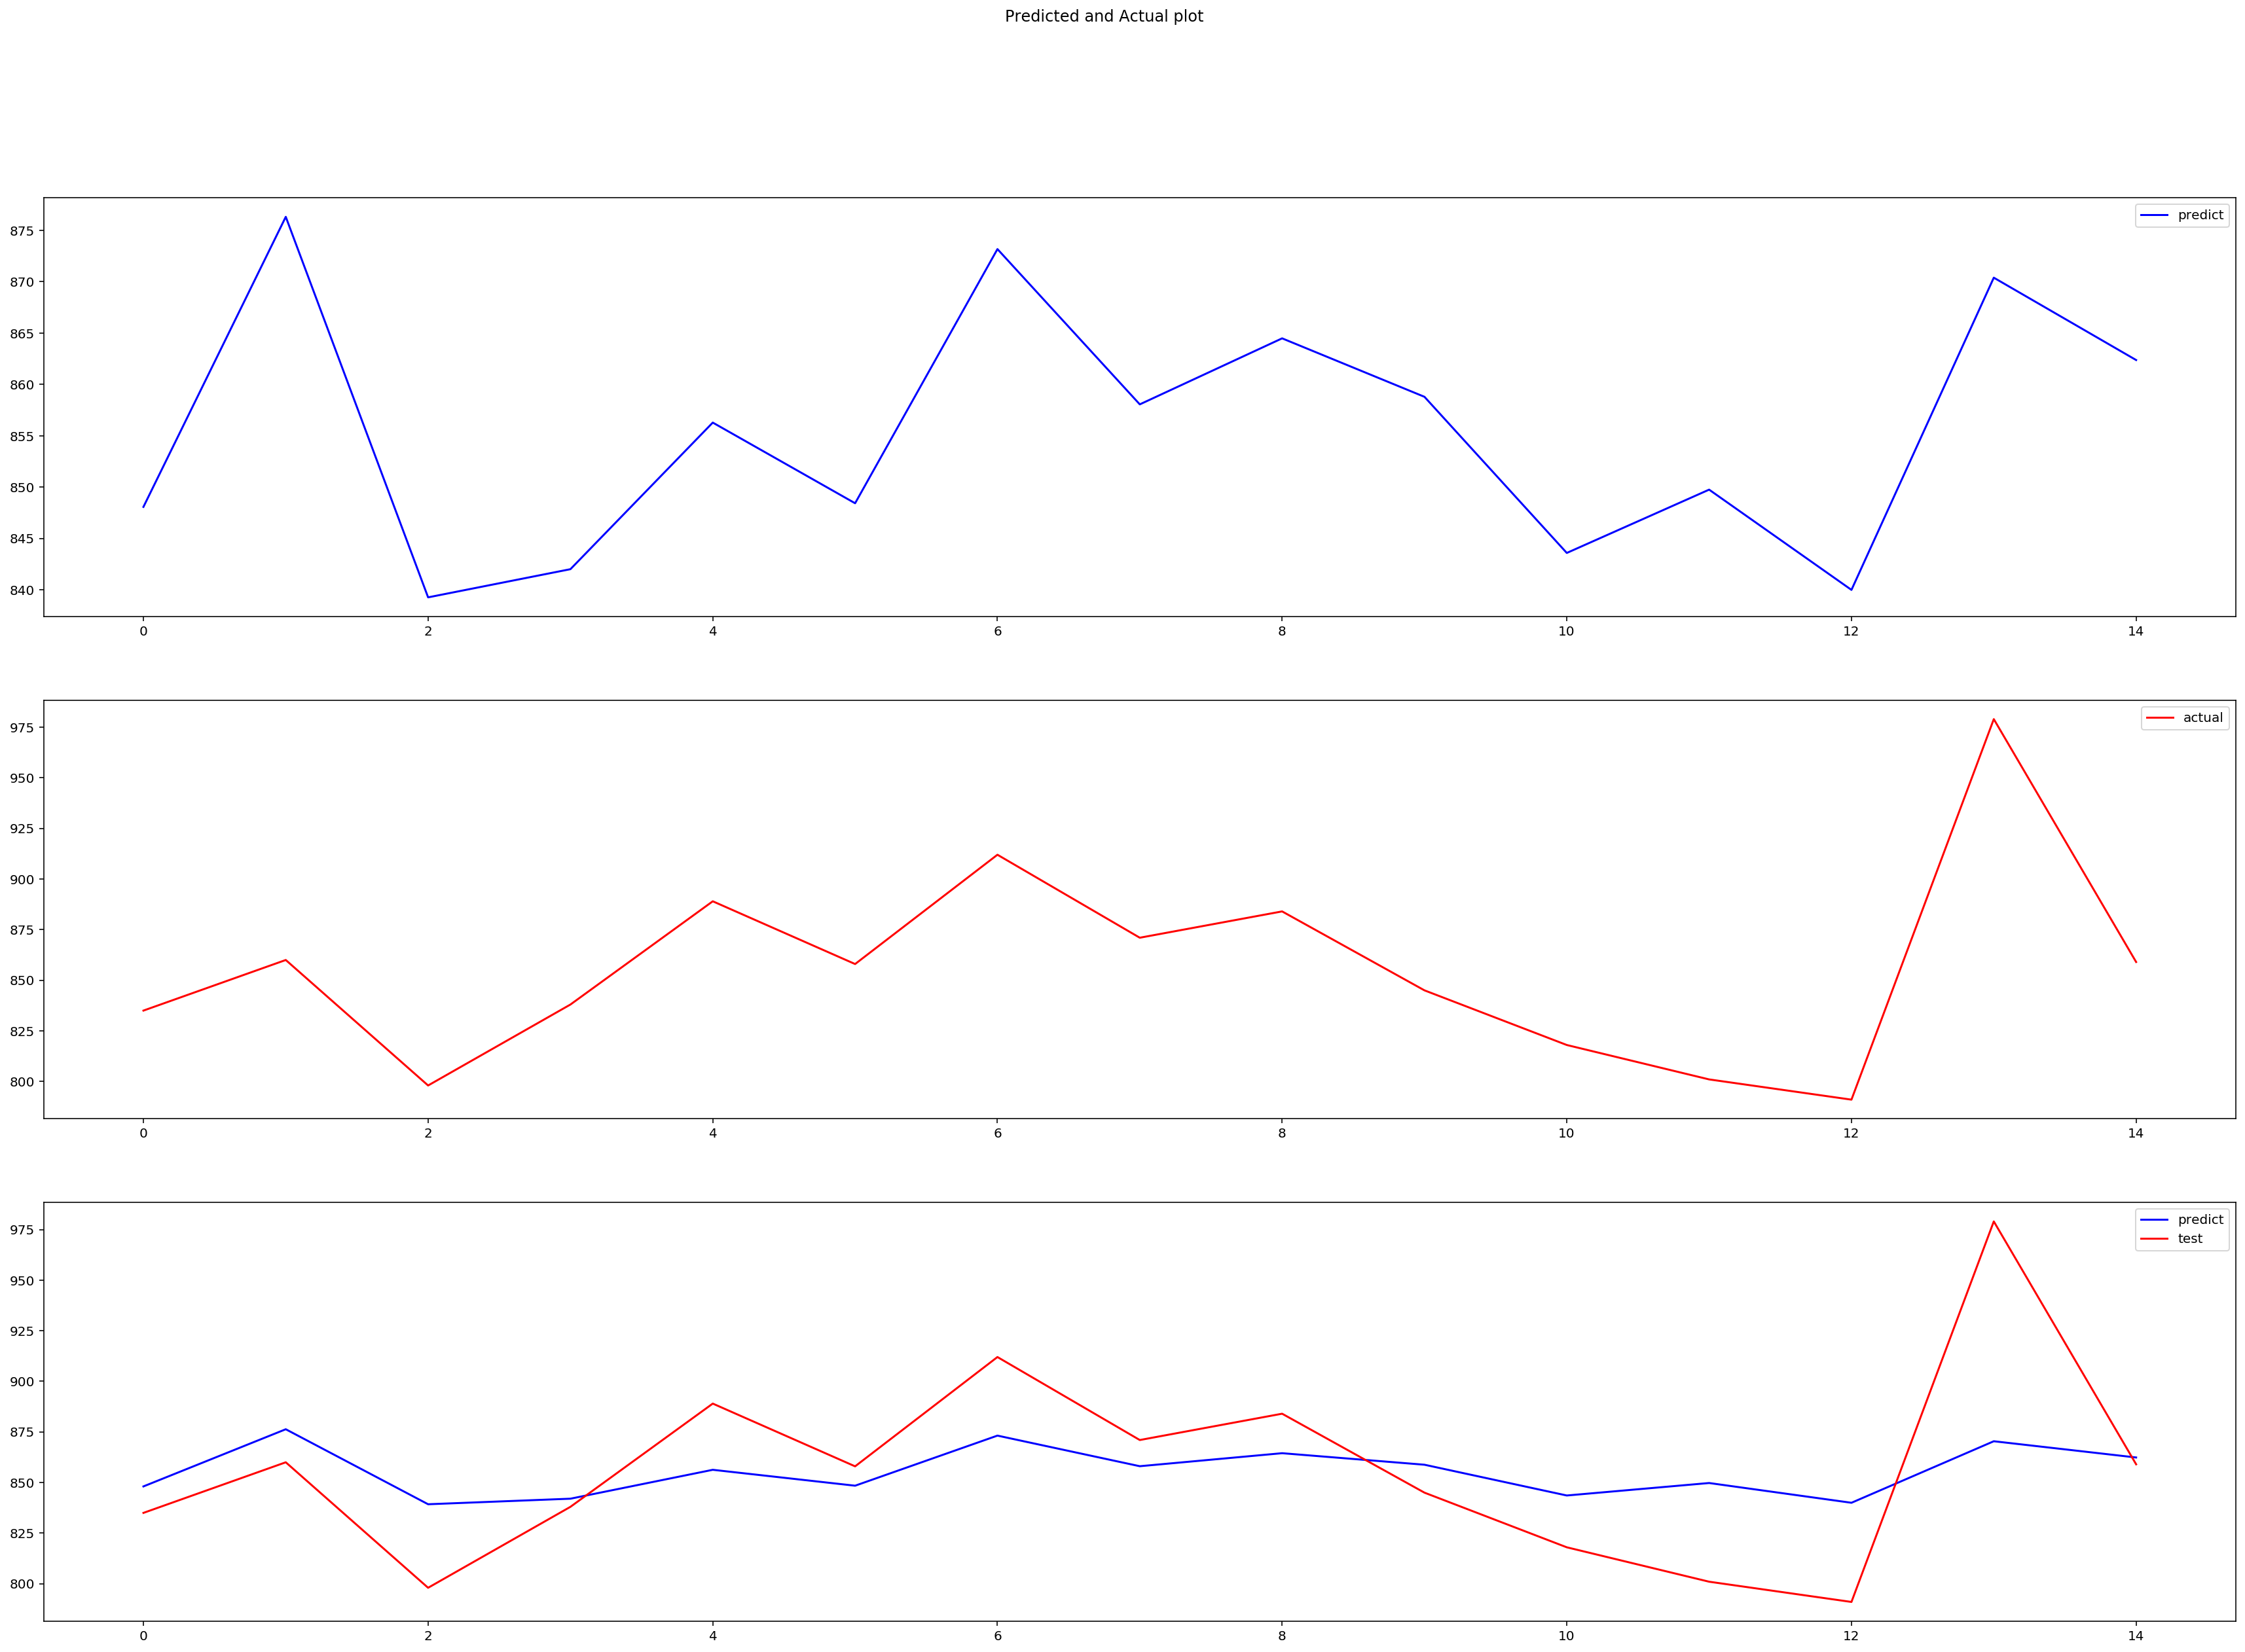

In [46]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

### Industrial_ANN

In [47]:
features_ANN_i=['Month', 'Industrial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Industrial_Retail Price']
#Spring is the seasonal feature baseline
data_WY_ANN=data[data.WY==1]
data_WY_ANN=data_WY_ANN[features_ANN_i]
data_WY_ANN

,Month,Industrial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Industrial_Retail Price
49,1,890,0.000000,11.258333,1320.406393,582531,0,0,0,1,6.30
99,2,839,0.000000,10.750000,1283.599078,582788,0,0,0,1,6.63
149,3,809,0.000000,10.866667,1051.477064,583045,0,0,0,0,6.73
199,4,801,0.000000,11.033333,813.004546,583302,0,0,0,0,6.57
249,5,889,4.495495,9.325000,519.815315,583558,0,0,0,0,6.57
...,...,...,...,...,...,...,...,...,...,...,...
3399,8,839,65.274775,7.426316,126.036036,579435,0,1,0,0,6.91
3449,9,872,25.626728,8.283333,337.004608,579531,0,0,1,0,6.69
3499,10,789,0.000000,9.463158,989.926605,579628,0,0,1,0,6.81
3549,11,868,0.000000,8.168421,1064.133641,579724,0,0,1,0,6.81


In [48]:
train_ANN, test_ANN = train_test_split(data_WY_ANN, test_size=0.2)
X_train_ANN_i, y_train_ANN_i = x_y_split(train_ANN, 'Industrial_Usage', ['Industrial_Usage'])
X_test_ANN_i,y_test_ANN_i = x_y_split(test_ANN, 'Industrial_Usage', ['Industrial_Usage'])

In [49]:
X_train_ANN_i, X_test_ANN_i = minmax_scaler(X_train_ANN_i, X_test_ANN_i, industrial_numeric_columns_adj)
y_train_ANN_i = (y_train_ANN_i - min(y_train_ANN_i))/(max(y_train_ANN_i) - min(y_train_ANN_i))

In [50]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_i, y_train_ANN_i, validation_split = 0.2, batch_size = 10, epochs = 1000)

Epoch 1/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0428 - mae: 0.1707 - val_loss: 0.0512 - val_mae: 0.1794
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0424 - mae: 0.1701 - val_loss: 0.0507 - val_mae: 0.1782
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0422 - mae: 0.1698 - val_loss: 0.0502 - val_mae: 0.1766
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0418 - mae: 0.1692 - val_loss: 0.0495 - val_mae: 0.1746
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0415 - mae: 0.1685 - val_loss: 0.0488 - val_mae: 0.1722
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0410 - mae: 0.1676 - val_loss: 0.0479 - val_mae: 0.1694
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0405 - mae: 0.1667 - val_loss: 0.0468 - val_mae: 0.1660
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0400 - mae:

5/5 [==============================] - 0s 10ms/step - loss: 0.0312 - mae: 0.1422 - val_loss: 0.0247 - val_mae: 0.1123
Epoch 64/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0311 - mae: 0.1419 - val_loss: 0.0247 - val_mae: 0.1121
Epoch 65/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0310 - mae: 0.1416 - val_loss: 0.0246 - val_mae: 0.1117
Epoch 66/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0309 - mae: 0.1414 - val_loss: 0.0243 - val_mae: 0.1112
Epoch 67/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0308 - mae: 0.1410 - val_loss: 0.0241 - val_mae: 0.1106
Epoch 68/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0307 - mae: 0.1407 - val_loss: 0.0239 - val_mae: 0.1103
Epoch 69/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0306 - mae: 0.1404 - val_loss: 0.0238 - val_mae: 0.1099
Epoch 70/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0305 - mae: 0.1

Epoch 125/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0227 - mae: 0.1227 - val_loss: 0.0150 - val_mae: 0.0993
Epoch 126/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0226 - mae: 0.1228 - val_loss: 0.0150 - val_mae: 0.0996
Epoch 127/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0224 - mae: 0.1223 - val_loss: 0.0151 - val_mae: 0.0997
Epoch 128/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0225 - mae: 0.1220 - val_loss: 0.0148 - val_mae: 0.0999
Epoch 129/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0223 - mae: 0.1214 - val_loss: 0.0149 - val_mae: 0.1000
Epoch 130/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0222 - mae: 0.1215 - val_loss: 0.0152 - val_mae: 0.1003
Epoch 131/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0222 - mae: 0.1213 - val_loss: 0.0152 - val_mae: 0.1005
Epoch 132/1000
5/5 [==============================] - ETA: 0s - loss: 0.

Epoch 186/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0199 - mae: 0.1131 - val_loss: 0.0150 - val_mae: 0.1026
Epoch 187/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0198 - mae: 0.1127 - val_loss: 0.0146 - val_mae: 0.1023
Epoch 188/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0197 - mae: 0.1123 - val_loss: 0.0144 - val_mae: 0.1021
Epoch 189/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0198 - mae: 0.1121 - val_loss: 0.0144 - val_mae: 0.1021
Epoch 190/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0197 - mae: 0.1125 - val_loss: 0.0150 - val_mae: 0.1025
Epoch 191/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0196 - mae: 0.1122 - val_loss: 0.0148 - val_mae: 0.1025
Epoch 192/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0196 - mae: 0.1123 - val_loss: 0.0149 - val_mae: 0.1028
Epoch 193/1000
5/5 [==============================] - 0s 11ms/step - lo

Epoch 248/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0179 - mae: 0.1057 - val_loss: 0.0150 - val_mae: 0.1042
Epoch 249/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0178 - mae: 0.1053 - val_loss: 0.0150 - val_mae: 0.1042
Epoch 250/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0178 - mae: 0.1053 - val_loss: 0.0152 - val_mae: 0.1043
Epoch 251/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0178 - mae: 0.1056 - val_loss: 0.0157 - val_mae: 0.1046
Epoch 252/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0177 - mae: 0.1059 - val_loss: 0.0160 - val_mae: 0.1048
Epoch 253/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0177 - mae: 0.1058 - val_loss: 0.0158 - val_mae: 0.1049
Epoch 254/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0177 - mae: 0.1056 - val_loss: 0.0157 - val_mae: 0.1048
Epoch 255/1000
5/5 [==============================] - 0s 8ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 0.0161 - mae: 0.0977 - val_loss: 0.0160 - val_mae: 0.1061
Epoch 310/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0160 - mae: 0.0977 - val_loss: 0.0160 - val_mae: 0.1061
Epoch 311/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.0977 - val_loss: 0.0158 - val_mae: 0.1056
Epoch 312/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.0976 - val_loss: 0.0159 - val_mae: 0.1054
Epoch 313/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.0978 - val_loss: 0.0158 - val_mae: 0.1052
Epoch 314/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.0976 - val_loss: 0.0161 - val_mae: 0.1058
Epoch 315/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0161 - mae: 0.0982 - val_loss: 0.0168 - val_mae: 0.1061
Epoch 316/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0159 - mae: 

Epoch 371/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0148 - mae: 0.0918 - val_loss: 0.0163 - val_mae: 0.1061
Epoch 372/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0150 - mae: 0.0916 - val_loss: 0.0161 - val_mae: 0.1060
Epoch 373/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0147 - mae: 0.0912 - val_loss: 0.0167 - val_mae: 0.1060
Epoch 374/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0147 - mae: 0.0930 - val_loss: 0.0175 - val_mae: 0.1061
Epoch 375/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0146 - mae: 0.0928 - val_loss: 0.0174 - val_mae: 0.1062
Epoch 376/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0146 - mae: 0.0926 - val_loss: 0.0171 - val_mae: 0.1061
Epoch 377/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.0920 - val_loss: 0.0166 - val_mae: 0.1066
Epoch 378/1000
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 8ms/step - loss: 0.0139 - mae: 0.0883 - val_loss: 0.0167 - val_mae: 0.1056
Epoch 433/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0138 - mae: 0.0875 - val_loss: 0.0172 - val_mae: 0.1054
Epoch 434/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0137 - mae: 0.0883 - val_loss: 0.0175 - val_mae: 0.1053
Epoch 435/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0137 - mae: 0.0889 - val_loss: 0.0177 - val_mae: 0.1052
Epoch 436/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0137 - mae: 0.0888 - val_loss: 0.0174 - val_mae: 0.1053
Epoch 437/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0137 - mae: 0.0884 - val_loss: 0.0176 - val_mae: 0.1052
Epoch 438/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0884 - val_loss: 0.0173 - val_mae: 0.1052
Epoch 439/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.0137 - mae: 

Epoch 494/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0132 - mae: 0.0856 - val_loss: 0.0171 - val_mae: 0.1038
Epoch 495/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0131 - mae: 0.0854 - val_loss: 0.0168 - val_mae: 0.1037
Epoch 496/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0131 - mae: 0.0849 - val_loss: 0.0168 - val_mae: 0.1036
Epoch 497/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0132 - mae: 0.0851 - val_loss: 0.0169 - val_mae: 0.1036
Epoch 498/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0132 - mae: 0.0851 - val_loss: 0.0168 - val_mae: 0.1035
Epoch 499/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0131 - mae: 0.0847 - val_loss: 0.0171 - val_mae: 0.1037
Epoch 500/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0133 - mae: 0.0862 - val_loss: 0.0175 - val_mae: 0.1042
Epoch 501/1000
5/5 [==============================] - 0s 10ms/step - l

Epoch 556/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0126 - mae: 0.0836 - val_loss: 0.0163 - val_mae: 0.1019
Epoch 557/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0127 - mae: 0.0831 - val_loss: 0.0164 - val_mae: 0.1018
Epoch 558/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0127 - mae: 0.0836 - val_loss: 0.0168 - val_mae: 0.1020
Epoch 559/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0126 - mae: 0.0833 - val_loss: 0.0166 - val_mae: 0.1019
Epoch 560/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0126 - mae: 0.0830 - val_loss: 0.0165 - val_mae: 0.1017
Epoch 561/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0128 - mae: 0.0834 - val_loss: 0.0167 - val_mae: 0.1020
Epoch 562/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0127 - mae: 0.0839 - val_loss: 0.0176 - val_mae: 0.1019
Epoch 563/1000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 0.0122 - mae: 0.0819 - val_loss: 0.0171 - val_mae: 0.1027
Epoch 618/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0122 - mae: 0.0817 - val_loss: 0.0168 - val_mae: 0.1025
Epoch 619/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0122 - mae: 0.0816 - val_loss: 0.0168 - val_mae: 0.1023
Epoch 620/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0816 - val_loss: 0.0172 - val_mae: 0.1022
Epoch 621/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0122 - mae: 0.0821 - val_loss: 0.0173 - val_mae: 0.1023
Epoch 622/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0121 - mae: 0.0819 - val_loss: 0.0175 - val_mae: 0.1027
Epoch 623/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0824 - val_loss: 0.0173 - val_mae: 0.1029
Epoch 624/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0120 - mae

Epoch 679/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0118 - mae: 0.0798 - val_loss: 0.0173 - val_mae: 0.1026
Epoch 680/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0116 - mae: 0.0791 - val_loss: 0.0172 - val_mae: 0.1022
Epoch 681/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0116 - mae: 0.0792 - val_loss: 0.0178 - val_mae: 0.1031
Epoch 682/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0117 - mae: 0.0799 - val_loss: 0.0179 - val_mae: 0.1038
Epoch 683/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0116 - mae: 0.0798 - val_loss: 0.0182 - val_mae: 0.1043
Epoch 684/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0117 - mae: 0.0801 - val_loss: 0.0182 - val_mae: 0.1045
Epoch 685/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0116 - mae: 0.0799 - val_loss: 0.0180 - val_mae: 0.1040
Epoch 686/1000
5/5 [==============================] - 0s 11ms/step - l

Epoch 741/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0784 - val_loss: 0.0179 - val_mae: 0.1051
Epoch 742/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0111 - mae: 0.0782 - val_loss: 0.0176 - val_mae: 0.1044
Epoch 743/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0778 - val_loss: 0.0170 - val_mae: 0.1030
Epoch 744/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0111 - mae: 0.0778 - val_loss: 0.0174 - val_mae: 0.1037
Epoch 745/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0778 - val_loss: 0.0173 - val_mae: 0.1037
Epoch 746/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0775 - val_loss: 0.0172 - val_mae: 0.1034
Epoch 747/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0110 - mae: 0.0775 - val_loss: 0.0175 - val_mae: 0.1042
Epoch 748/1000
5/5 [==============================] - 0s 9ms/step - loss

Epoch 803/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.0105 - mae: 0.0768 - val_loss: 0.0172 - val_mae: 0.1051
Epoch 804/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0103 - mae: 0.0760 - val_loss: 0.0187 - val_mae: 0.1087
Epoch 805/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0106 - mae: 0.0774 - val_loss: 0.0188 - val_mae: 0.1089
Epoch 806/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0105 - mae: 0.0765 - val_loss: 0.0176 - val_mae: 0.1062
Epoch 807/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0104 - mae: 0.0765 - val_loss: 0.0176 - val_mae: 0.1064
Epoch 808/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0104 - mae: 0.0765 - val_loss: 0.0179 - val_mae: 0.1066
Epoch 809/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.0760 - val_loss: 0.0179 - val_mae: 0.1068
Epoch 810/1000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 8ms/step - loss: 0.0102 - mae: 0.0755 - val_loss: 0.0171 - val_mae: 0.1065
Epoch 865/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0099 - mae: 0.0752 - val_loss: 0.0184 - val_mae: 0.1085
Epoch 866/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0101 - mae: 0.0754 - val_loss: 0.0184 - val_mae: 0.1086
Epoch 867/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0100 - mae: 0.0749 - val_loss: 0.0183 - val_mae: 0.1081
Epoch 868/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0099 - mae: 0.0745 - val_loss: 0.0181 - val_mae: 0.1079
Epoch 869/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0098 - mae: 0.0742 - val_loss: 0.0176 - val_mae: 0.1074
Epoch 870/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0100 - mae: 0.0758 - val_loss: 0.0171 - val_mae: 0.1066
Epoch 871/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0098 - mae:

Epoch 926/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0093 - mae: 0.0723 - val_loss: 0.0177 - val_mae: 0.1085
Epoch 927/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0092 - mae: 0.0718 - val_loss: 0.0183 - val_mae: 0.1099
Epoch 928/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0092 - mae: 0.0718 - val_loss: 0.0193 - val_mae: 0.1117
Epoch 929/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0094 - mae: 0.0725 - val_loss: 0.0197 - val_mae: 0.1123
Epoch 930/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0093 - mae: 0.0721 - val_loss: 0.0183 - val_mae: 0.1101
Epoch 931/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0093 - mae: 0.0729 - val_loss: 0.0173 - val_mae: 0.1080
Epoch 932/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0094 - mae: 0.0732 - val_loss: 0.0174 - val_mae: 0.1082
Epoch 933/1000
5/5 [==============================] - 0s 8ms/step - loss:

Epoch 988/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0087 - mae: 0.0705 - val_loss: 0.0184 - val_mae: 0.1095
Epoch 989/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0088 - mae: 0.0705 - val_loss: 0.0183 - val_mae: 0.1088
Epoch 990/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0087 - mae: 0.0698 - val_loss: 0.0182 - val_mae: 0.1086
Epoch 991/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0086 - mae: 0.0697 - val_loss: 0.0175 - val_mae: 0.1075
Epoch 992/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0087 - mae: 0.0702 - val_loss: 0.0174 - val_mae: 0.1075
Epoch 993/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0089 - mae: 0.0716 - val_loss: 0.0188 - val_mae: 0.1102
Epoch 994/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0087 - mae: 0.0703 - val_loss: 0.0183 - val_mae: 0.1093
Epoch 995/1000
5/5 [==============================] - 0s 11ms/step - los

In [51]:
# Predicting the Test set results
predictions_ANN_i = classifier.predict(X_test_ANN_i)
# Scale y back 
predictions_ANN_i = (predictions_ANN_i * (max(y_test_ANN_i) - min(y_test_ANN_i))) + min(y_test_ANN_i)
predictions_ANN_i = predictions_ANN_i.reshape(-1)
df_pred_ANN_i = pd.DataFrame({'Actual': y_test_ANN_i, 'Predicted': predictions_ANN_i})

In [52]:
df_pred_ANN_i

,Actual,Predicted
2799,884,835.188477
1449,791,819.841919
1549,855,855.031189
399,863,825.695007
2299,844,816.573608
1899,818,812.005127
1149,879,841.192200
3599,883,848.530151
3499,789,822.671509
449,833,844.846008


In [53]:
evaluate_performances(y_test_ANN_i, predictions_ANN_i)

Performance Evaluation
Mean Absolute Error: 27.112186686197916
Mean Squared Error: 1007.8535212712983
Root Mean Squared Error: 31.746708825818438


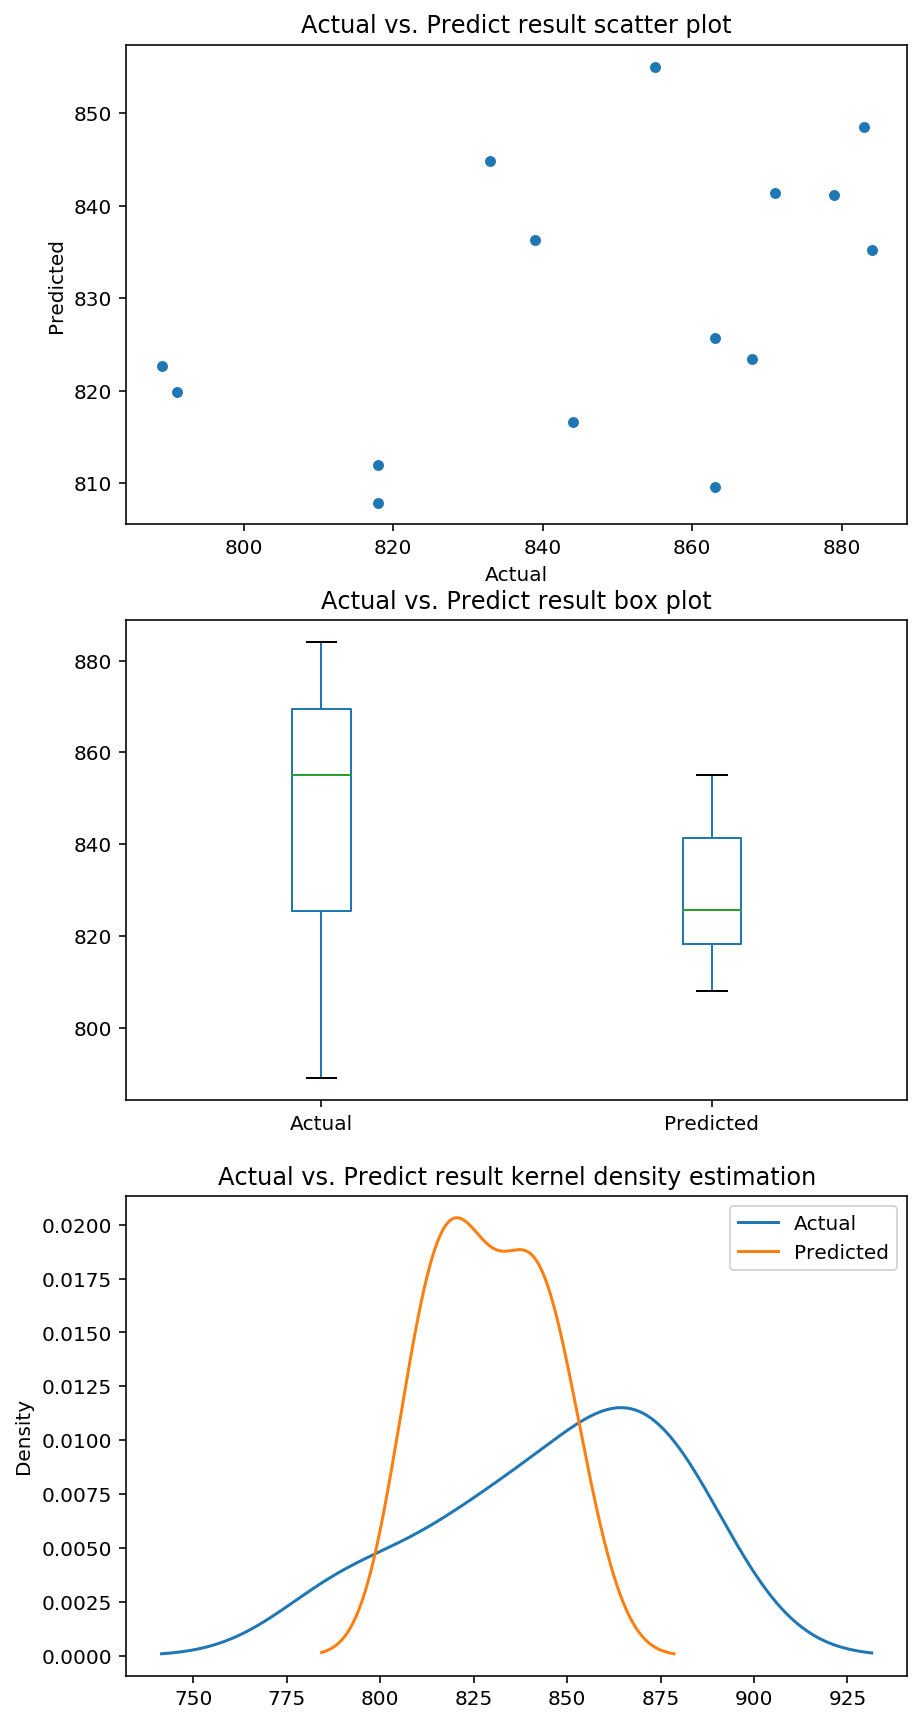

In [54]:
visualize_graph(df_pred_ANN_i)

## Residential Consumption Forecast

In [55]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     83.85
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           1.48e-25
Time:                        16:31:54   Log-Likelihood:                -225.97
No. Observations:                  57   AIC:                             469.9
Df Residuals:                      48   BIC:                             488.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [56]:
df_pred_r

,Actual,Predicted
1499,188.0,198.849747
1199,296.0,306.806198
1399,212.0,216.542804
1649,171.0,160.327594
249,201.0,205.017934
3249,190.0,206.288399
2749,224.0,218.148620
2399,300.0,297.324384
2799,202.0,204.222785
2849,163.0,157.060306


In [57]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 10.2209363045067
Mean Squared Error: 147.74575513047782
Root Mean Squared Error: 12.155071169288883


## Residential_Feature Importance

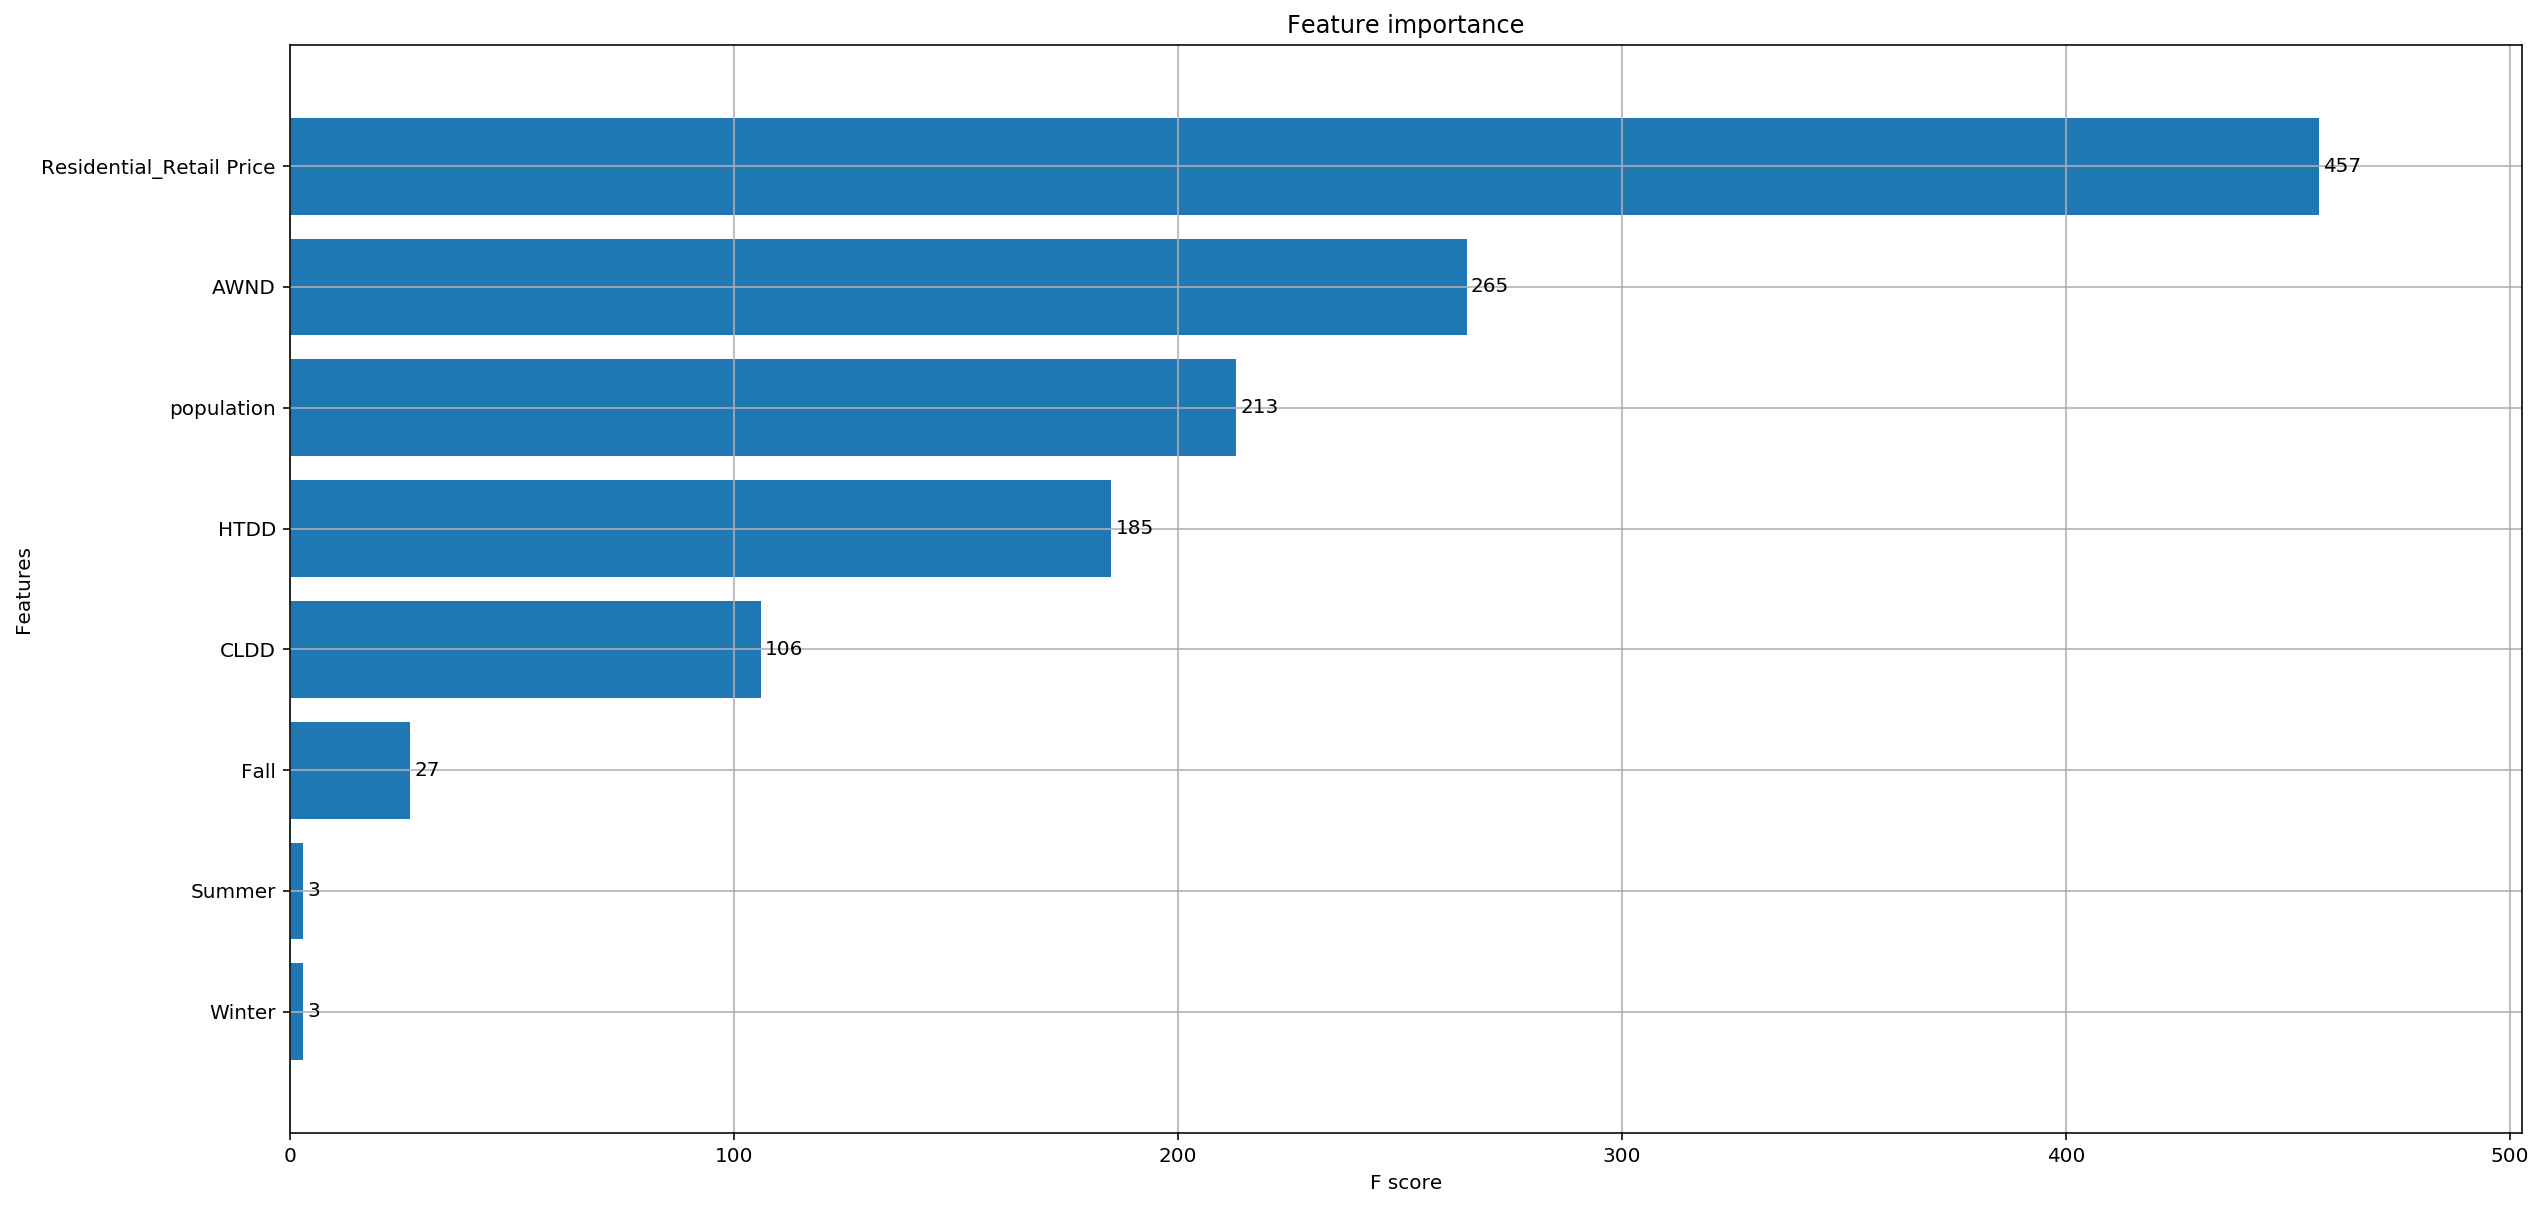

In [58]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


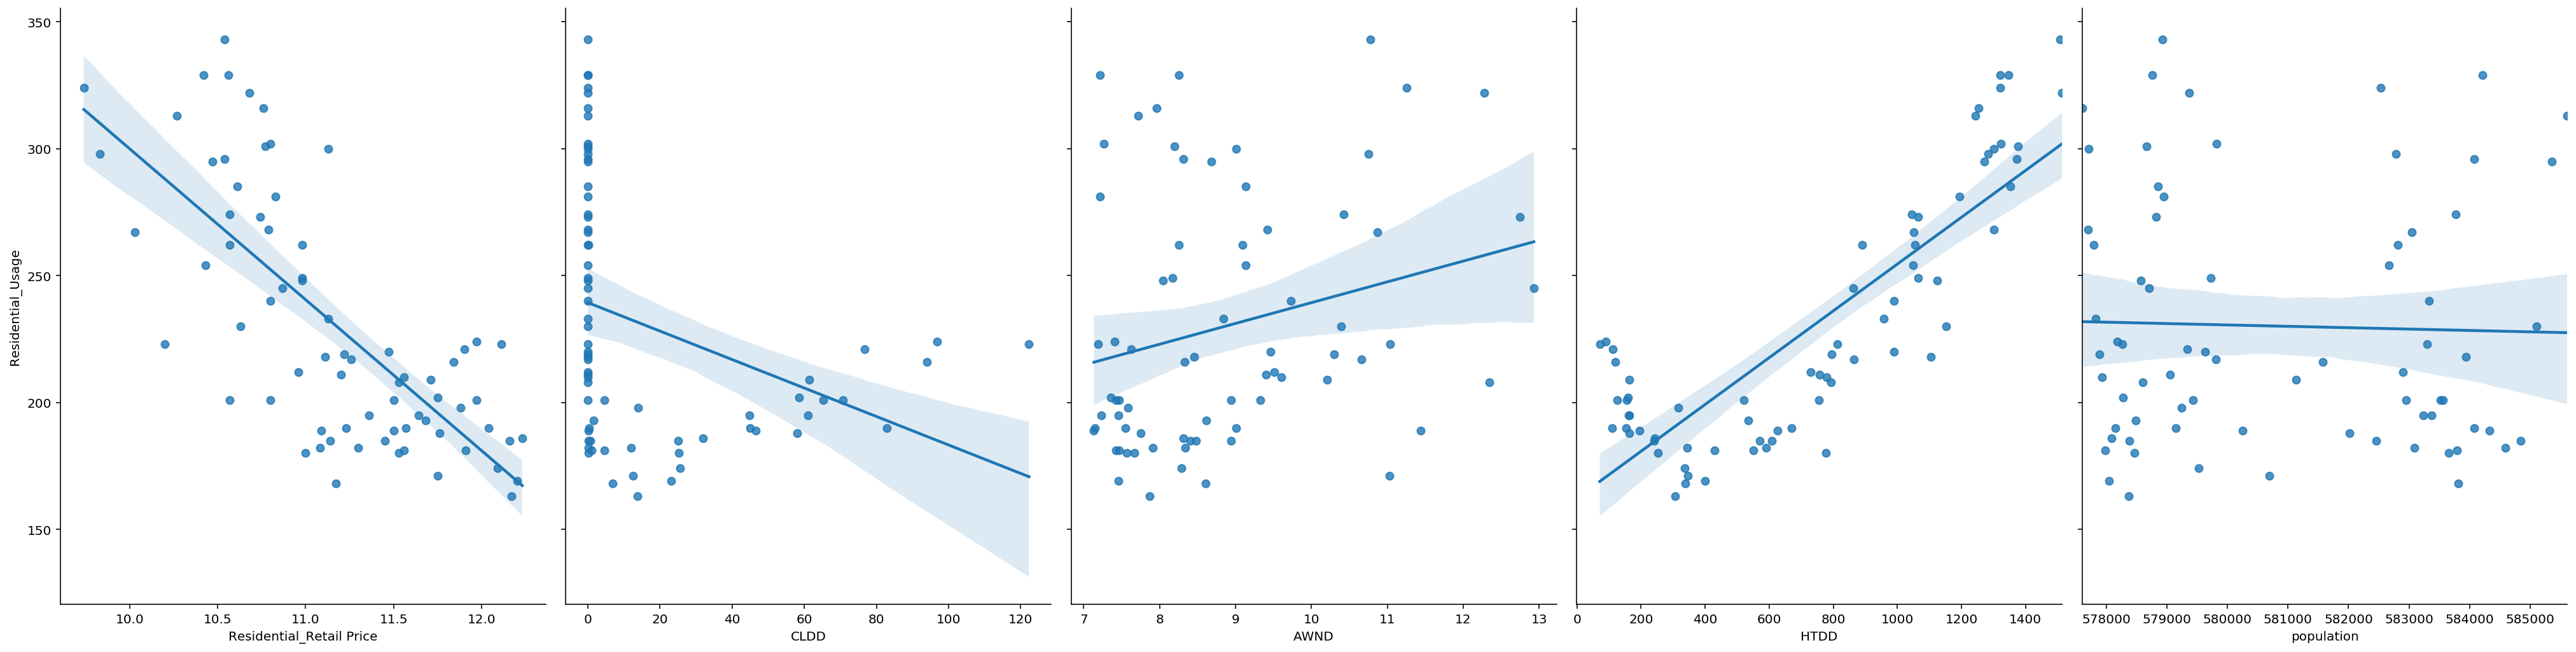

In [59]:
# Correlation Analysis
correlation_analysis(data_WY, residential_numeric_columns_adj, ['Residential_Usage'])

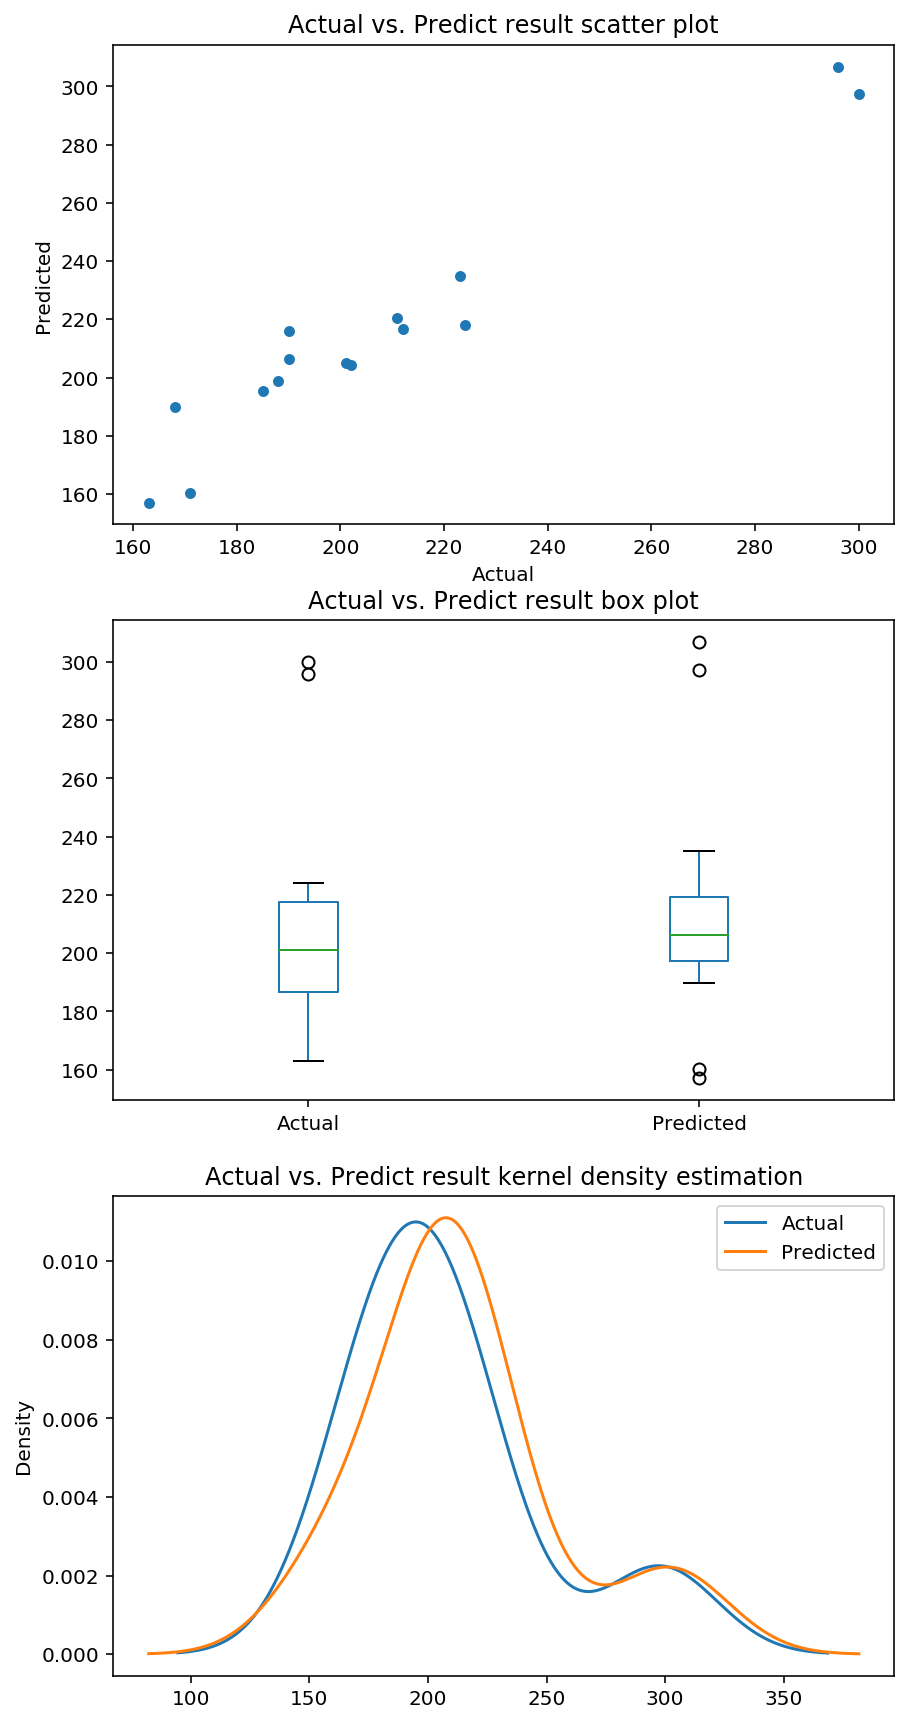

In [60]:
visualize_graph(df_pred_r)

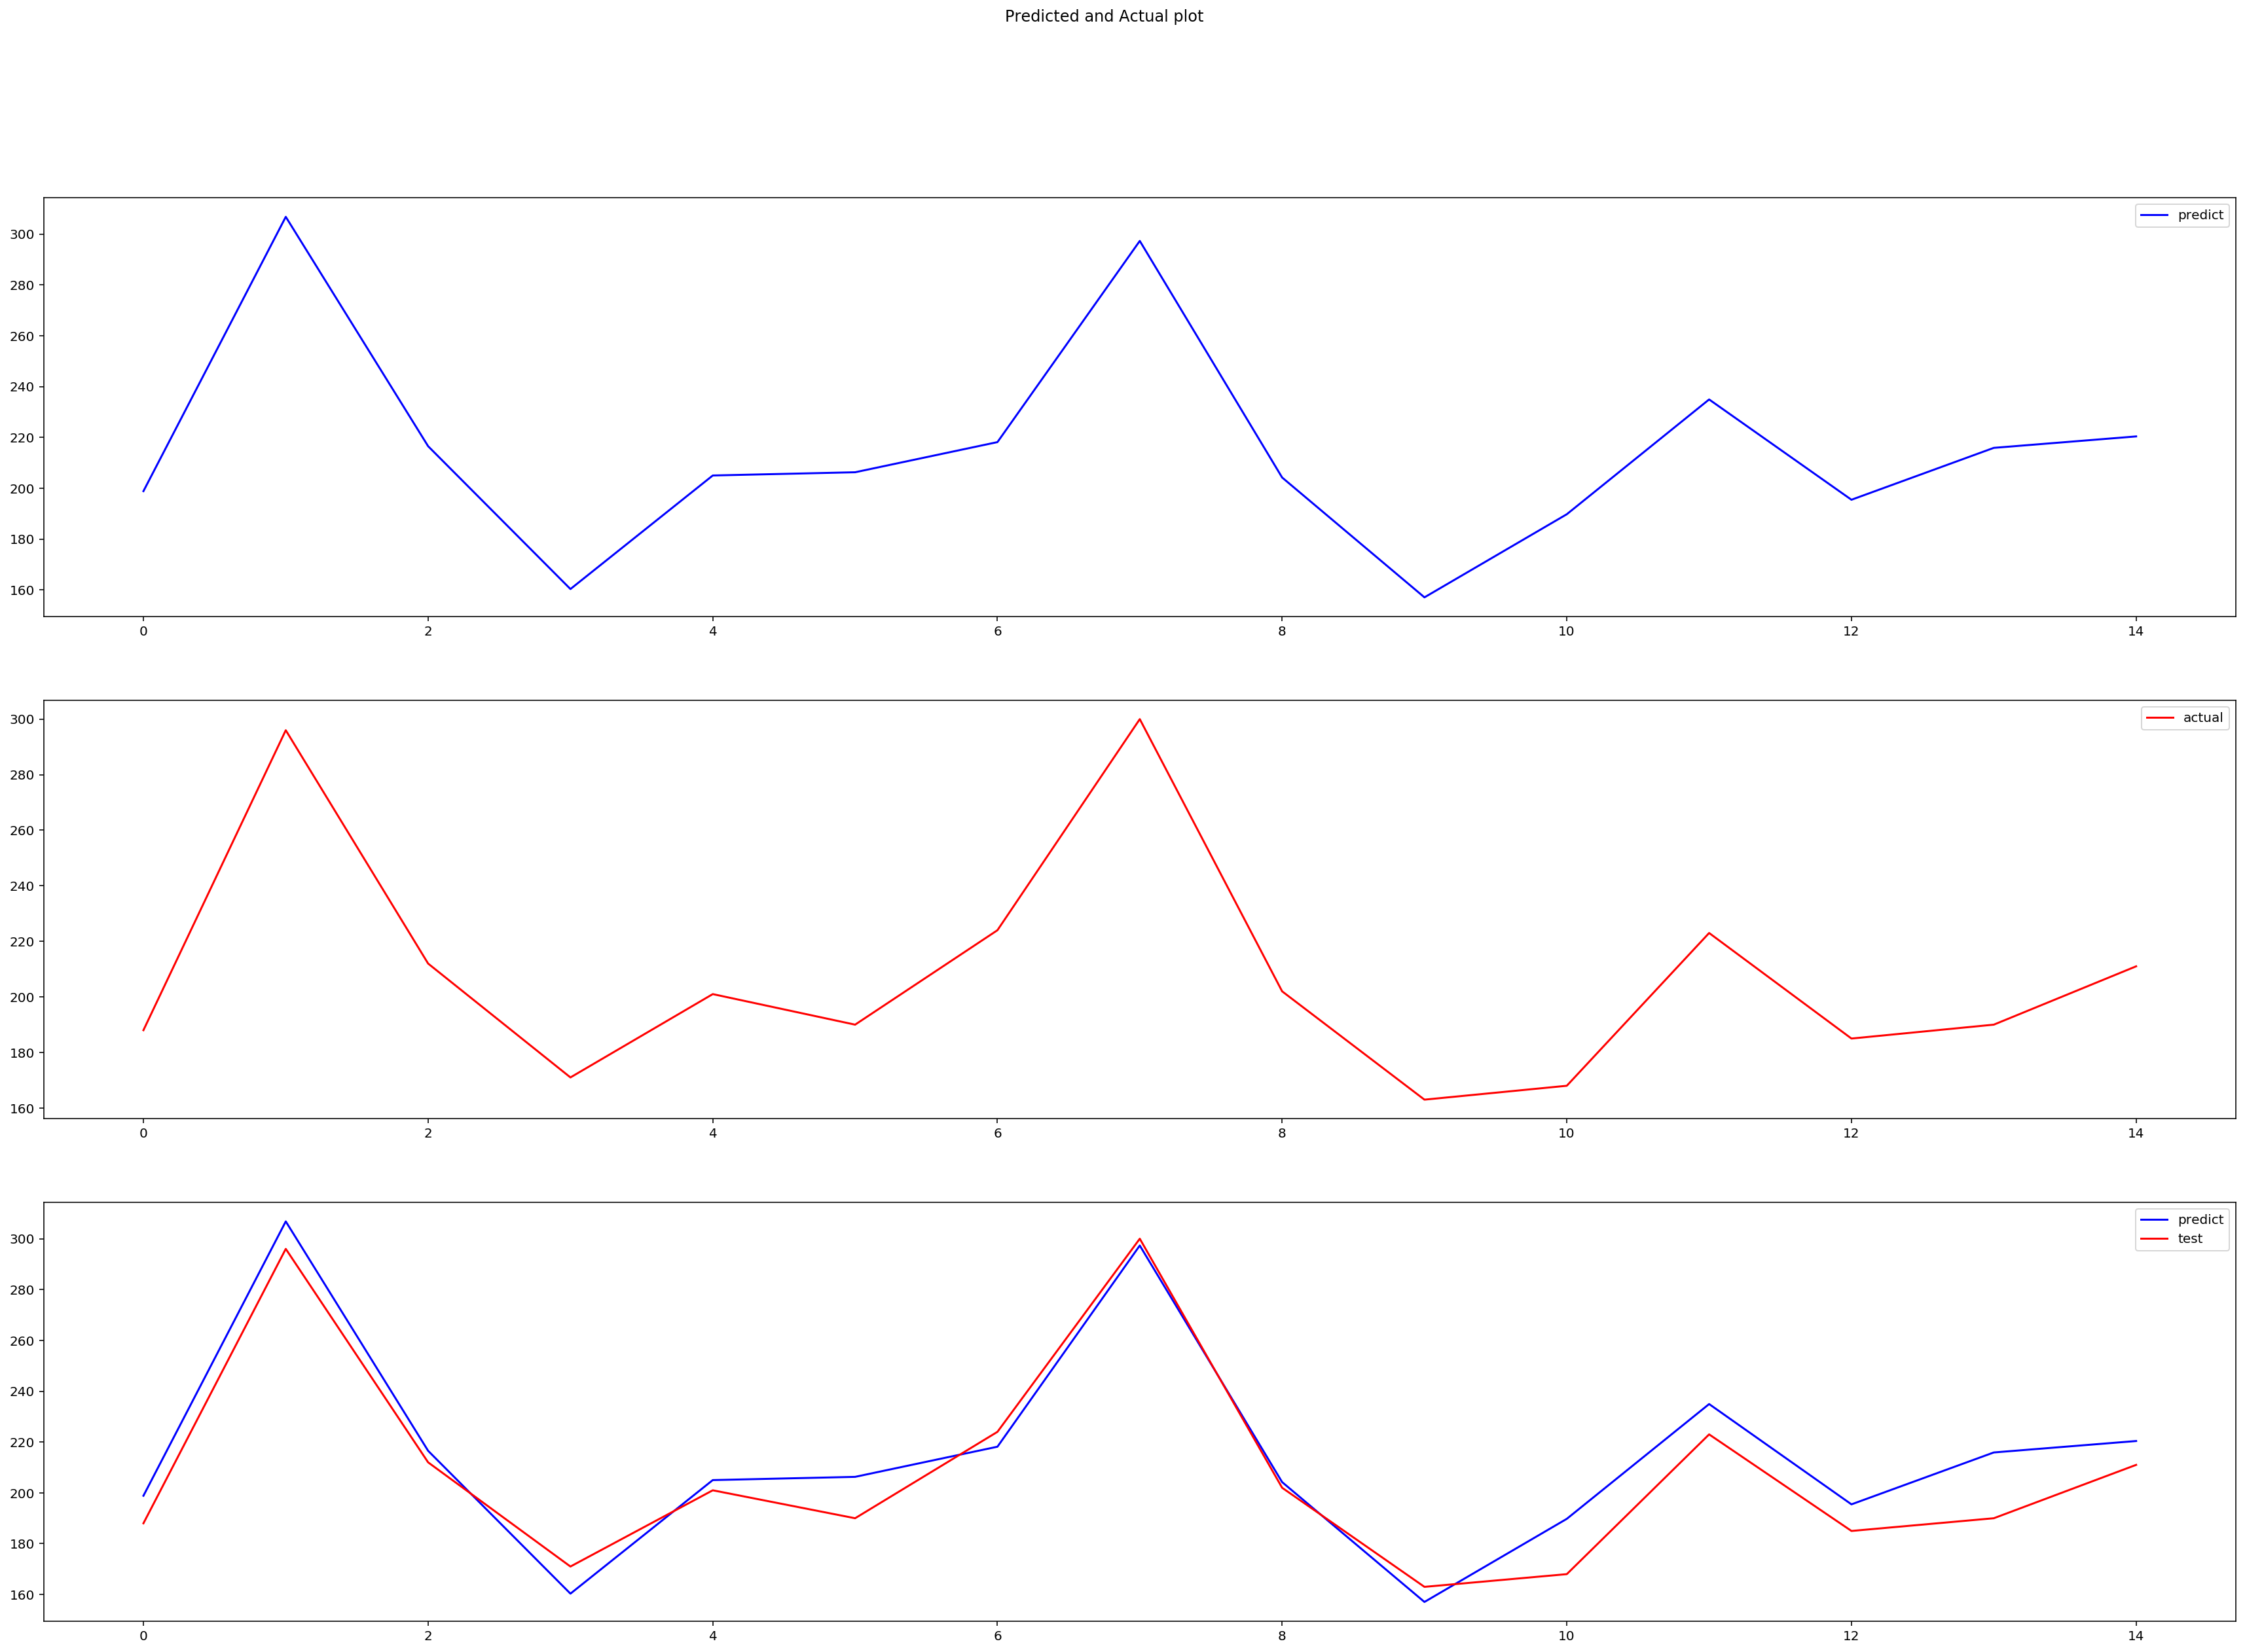

In [61]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)

### Residential_ANN

In [62]:
features_ANN_r=['Month', 'Residential_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Retail Price']
#Spring is the seasonal feature baseline
data_WY_ANN=data[data.WY==1]
data_WY_ANN=data_WY_ANN[features_ANN_r]
data_WY_ANN


,Month,Residential_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Residential_Retail Price
49,1,324.0,0.000000,11.258333,1320.406393,582531,0,0,0,1,9.74
99,2,298.0,0.000000,10.750000,1283.599078,582788,0,0,0,1,9.83
149,3,267.0,0.000000,10.866667,1051.477064,583045,0,0,0,0,10.03
199,4,223.0,0.000000,11.033333,813.004546,583302,0,0,0,0,10.20
249,5,201.0,4.495495,9.325000,519.815315,583558,0,0,0,0,10.57
...,...,...,...,...,...,...,...,...,...,...,...
3399,8,201.0,65.274775,7.426316,126.036036,579435,0,1,0,0,11.97
3449,9,174.0,25.626728,8.283333,337.004608,579531,0,0,1,0,12.09
3499,10,220.0,0.000000,9.463158,989.926605,579628,0,0,1,0,11.47
3549,11,249.0,0.000000,8.168421,1064.133641,579724,0,0,1,0,10.98


In [63]:
train_ANN, test_ANN = train_test_split(data_WY_ANN, test_size=0.2)
X_train_ANN_r, y_train_ANN_r = x_y_split(train_ANN, 'Residential_Usage', ['Residential_Usage'])
X_test_ANN_r,y_test_ANN_r = x_y_split(test_ANN, 'Residential_Usage', ['Residential_Usage'])


In [64]:
X_train_ANN_r, X_test_ANN_r = minmax_scaler(X_train_ANN_r, X_test_ANN_r, residential_numeric_columns_adj)
y_train_ANN_r = (y_train_ANN_r - min(y_train_ANN_r))/(max(y_train_ANN_r) - min(y_train_ANN_r))


In [65]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_r, y_train_ANN_r, validation_split = 0.2, batch_size = 10, epochs = 1000)


Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.0884 - mae: 0.2688 - val_loss: 0.1117 - val_mae: 0.3117
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0881 - mae: 0.2683 - val_loss: 0.1110 - val_mae: 0.3108
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0878 - mae: 0.2677 - val_loss: 0.1103 - val_mae: 0.3100
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0874 - mae: 0.2670 - val_loss: 0.1094 - val_mae: 0.3090
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0870 - mae: 0.2664 - val_loss: 0.1085 - val_mae: 0.3078
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0866 - mae: 0.2657 - val_loss: 0.1074 - val_mae: 0.3065
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0861 - mae: 0.2648 - val_loss: 0.1065 - val_mae: 0.3053
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0856 - m

5/5 [==============================] - 0s 10ms/step - loss: 0.0283 - mae: 0.1365 - val_loss: 0.0262 - val_mae: 0.1480
Epoch 64/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0276 - mae: 0.1352 - val_loss: 0.0266 - val_mae: 0.1488
Epoch 65/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0270 - mae: 0.1341 - val_loss: 0.0267 - val_mae: 0.1493
Epoch 66/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0263 - mae: 0.1331 - val_loss: 0.0259 - val_mae: 0.1470
Epoch 67/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0256 - mae: 0.1318 - val_loss: 0.0255 - val_mae: 0.1459
Epoch 68/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0251 - mae: 0.1309 - val_loss: 0.0246 - val_mae: 0.1435
Epoch 69/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0245 - mae: 0.1299 - val_loss: 0.0246 - val_mae: 0.1437
Epoch 70/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0239 - mae: 0.1

5/5 [==============================] - 0s 10ms/step - loss: 0.0125 - mae: 0.0950 - val_loss: 0.0117 - val_mae: 0.1012
Epoch 126/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0124 - mae: 0.0947 - val_loss: 0.0114 - val_mae: 0.1001
Epoch 127/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0124 - mae: 0.0945 - val_loss: 0.0113 - val_mae: 0.0991
Epoch 128/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0124 - mae: 0.0945 - val_loss: 0.0110 - val_mae: 0.0979
Epoch 129/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0123 - mae: 0.0941 - val_loss: 0.0112 - val_mae: 0.0986
Epoch 130/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0122 - mae: 0.0939 - val_loss: 0.0111 - val_mae: 0.0986
Epoch 131/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0122 - mae: 0.0937 - val_loss: 0.0112 - val_mae: 0.0992
Epoch 132/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0121 - mae

5/5 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.0865 - val_loss: 0.0092 - val_mae: 0.0871
Epoch 187/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.0864 - val_loss: 0.0091 - val_mae: 0.0861
Epoch 188/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0104 - mae: 0.0861 - val_loss: 0.0090 - val_mae: 0.0856
Epoch 189/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.0861 - val_loss: 0.0091 - val_mae: 0.0860
Epoch 190/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.0860 - val_loss: 0.0091 - val_mae: 0.0864
Epoch 191/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.0860 - val_loss: 0.0091 - val_mae: 0.0864
Epoch 192/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.0860 - val_loss: 0.0091 - val_mae: 0.0862
Epoch 193/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0103 - mae

Epoch 248/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0090 - mae: 0.0789 - val_loss: 0.0077 - val_mae: 0.0748
Epoch 249/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0090 - mae: 0.0786 - val_loss: 0.0078 - val_mae: 0.0752
Epoch 250/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0090 - mae: 0.0787 - val_loss: 0.0078 - val_mae: 0.0756
Epoch 251/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0090 - mae: 0.0785 - val_loss: 0.0078 - val_mae: 0.0756
Epoch 252/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0089 - mae: 0.0784 - val_loss: 0.0078 - val_mae: 0.0754
Epoch 253/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0089 - mae: 0.0785 - val_loss: 0.0078 - val_mae: 0.0759
Epoch 254/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0089 - mae: 0.0782 - val_loss: 0.0078 - val_mae: 0.0756
Epoch 255/1000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0710 - val_loss: 0.0068 - val_mae: 0.0676
Epoch 310/1000
5/5 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.058 - 0s 8ms/step - loss: 0.0078 - mae: 0.0710 - val_loss: 0.0067 - val_mae: 0.0659
Epoch 311/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0708 - val_loss: 0.0067 - val_mae: 0.0663
Epoch 312/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0707 - val_loss: 0.0067 - val_mae: 0.0667
Epoch 313/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0077 - mae: 0.0705 - val_loss: 0.0067 - val_mae: 0.0663
Epoch 314/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0077 - mae: 0.0703 - val_loss: 0.0067 - val_mae: 0.0664
Epoch 315/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0077 - mae: 0.0703 - val_loss: 0.0067 - val_mae: 0.0660
Epoch 316/1000
5/5 [==============================

5/5 [==============================] - 0s 8ms/step - loss: 0.0068 - mae: 0.0632 - val_loss: 0.0063 - val_mae: 0.0607
Epoch 371/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0068 - mae: 0.0633 - val_loss: 0.0063 - val_mae: 0.0600
Epoch 372/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0068 - mae: 0.0631 - val_loss: 0.0063 - val_mae: 0.0599
Epoch 373/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0628 - val_loss: 0.0063 - val_mae: 0.0600
Epoch 374/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0067 - mae: 0.0628 - val_loss: 0.0062 - val_mae: 0.0592
Epoch 375/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0625 - val_loss: 0.0062 - val_mae: 0.0587
Epoch 376/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0625 - val_loss: 0.0062 - val_mae: 0.0590
Epoch 377/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0067 - mae

Epoch 432/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0061 - mae: 0.0575 - val_loss: 0.0063 - val_mae: 0.0558
Epoch 433/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0061 - mae: 0.0569 - val_loss: 0.0063 - val_mae: 0.0556
Epoch 434/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0568 - val_loss: 0.0062 - val_mae: 0.0556
Epoch 435/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0575 - val_loss: 0.0061 - val_mae: 0.0559
Epoch 436/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0566 - val_loss: 0.0061 - val_mae: 0.0558
Epoch 437/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0060 - mae: 0.0566 - val_loss: 0.0061 - val_mae: 0.0559
Epoch 438/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0060 - mae: 0.0564 - val_loss: 0.0061 - val_mae: 0.0559
Epoch 439/1000
5/5 [==============================] - 0s 8ms/step - loss:

Epoch 494/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0056 - mae: 0.0538 - val_loss: 0.0065 - val_mae: 0.0553
Epoch 495/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0535 - val_loss: 0.0064 - val_mae: 0.0554
Epoch 496/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0536 - val_loss: 0.0065 - val_mae: 0.0553
Epoch 497/1000
5/5 [==============================] - ETA: 0s - loss: 0.0094 - mae: 0.072 - 0s 8ms/step - loss: 0.0055 - mae: 0.0535 - val_loss: 0.0064 - val_mae: 0.0555
Epoch 498/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0533 - val_loss: 0.0064 - val_mae: 0.0558
Epoch 499/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0532 - val_loss: 0.0064 - val_mae: 0.0556
Epoch 500/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0055 - mae: 0.0529 - val_loss: 0.0064 - val_mae: 0.0556
Epoch 501/1000
5/5 [==============

5/5 [==============================] - 0s 9ms/step - loss: 0.0051 - mae: 0.0507 - val_loss: 0.0068 - val_mae: 0.0561
Epoch 556/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0509 - val_loss: 0.0069 - val_mae: 0.0565
Epoch 557/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0051 - mae: 0.0512 - val_loss: 0.0069 - val_mae: 0.0569
Epoch 558/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0511 - val_loss: 0.0068 - val_mae: 0.0563
Epoch 559/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0508 - val_loss: 0.0070 - val_mae: 0.0574
Epoch 560/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0051 - mae: 0.0513 - val_loss: 0.0071 - val_mae: 0.0576
Epoch 561/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0512 - val_loss: 0.0070 - val_mae: 0.0572
Epoch 562/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0051 - mae

5/5 [==============================] - 0s 10ms/step - loss: 0.0047 - mae: 0.0478 - val_loss: 0.0074 - val_mae: 0.0580
Epoch 617/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0479 - val_loss: 0.0075 - val_mae: 0.0587
Epoch 618/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0479 - val_loss: 0.0077 - val_mae: 0.0596
Epoch 619/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0046 - mae: 0.0482 - val_loss: 0.0078 - val_mae: 0.0603
Epoch 620/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0485 - val_loss: 0.0077 - val_mae: 0.0599
Epoch 621/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0046 - mae: 0.0480 - val_loss: 0.0076 - val_mae: 0.0592
Epoch 622/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0477 - val_loss: 0.0075 - val_mae: 0.0584
Epoch 623/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0046 - ma

5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - mae: 0.0437 - val_loss: 0.0074 - val_mae: 0.0577
Epoch 678/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - mae: 0.0435 - val_loss: 0.0074 - val_mae: 0.0580
Epoch 679/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - mae: 0.0432 - val_loss: 0.0076 - val_mae: 0.0591
Epoch 680/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0036 - mae: 0.0436 - val_loss: 0.0077 - val_mae: 0.0597
Epoch 681/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0036 - mae: 0.0436 - val_loss: 0.0076 - val_mae: 0.0592
Epoch 682/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0036 - mae: 0.0434 - val_loss: 0.0075 - val_mae: 0.0589
Epoch 683/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0431 - val_loss: 0.0075 - val_mae: 0.0590
Epoch 684/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0035 - mae

5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0388 - val_loss: 0.0071 - val_mae: 0.0571
Epoch 739/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0388 - val_loss: 0.0071 - val_mae: 0.0569
Epoch 740/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0028 - mae: 0.0387 - val_loss: 0.0071 - val_mae: 0.0571
Epoch 741/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0392 - val_loss: 0.0072 - val_mae: 0.0575
Epoch 742/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0385 - val_loss: 0.0070 - val_mae: 0.0565
Epoch 743/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0384 - val_loss: 0.0067 - val_mae: 0.0551
Epoch 744/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0380 - val_loss: 0.0068 - val_mae: 0.0559
Epoch 745/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.0027 - ma

Epoch 800/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0558
Epoch 801/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0021 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0556
Epoch 802/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0069 - val_mae: 0.0552
Epoch 803/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0565
Epoch 804/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0568
Epoch 805/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0563
Epoch 806/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0021 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0559
Epoch 807/1000
5/5 [==============================] - 0s 10ms/step - lo

Epoch 862/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0314 - val_loss: 0.0075 - val_mae: 0.0558
Epoch 863/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0313 - val_loss: 0.0075 - val_mae: 0.0558
Epoch 864/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.0312 - val_loss: 0.0075 - val_mae: 0.0558
Epoch 865/1000
5/5 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.048 - 0s 8ms/step - loss: 0.0017 - mae: 0.0314 - val_loss: 0.0079 - val_mae: 0.0580
Epoch 866/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0323 - val_loss: 0.0079 - val_mae: 0.0579
Epoch 867/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0076 - val_mae: 0.0564
Epoch 868/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 0.0078 - val_mae: 0.0572
Epoch 869/1000
5/5 [==============

5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0306 - val_loss: 0.0081 - val_mae: 0.0605
Epoch 924/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0081 - val_mae: 0.0605
Epoch 925/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0079 - val_mae: 0.0590
Epoch 926/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 0.0079 - val_mae: 0.0592
Epoch 927/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0080 - val_mae: 0.0601
Epoch 928/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0079 - val_mae: 0.0597
Epoch 929/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0080 - val_mae: 0.0600
Epoch 930/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 

Epoch 985/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0082 - val_mae: 0.0608
Epoch 986/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0087 - val_mae: 0.0633
Epoch 987/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0294 - val_loss: 0.0088 - val_mae: 0.0638
Epoch 988/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0084 - val_mae: 0.0618
Epoch 989/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0083 - val_mae: 0.0614
Epoch 990/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0013 - mae: 0.0281 - val_loss: 0.0084 - val_mae: 0.0622
Epoch 991/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0287 - val_loss: 0.0084 - val_mae: 0.0623
Epoch 992/1000
5/5 [==============================] - 0s 10ms/step - lo

In [66]:
# Predicting the Test set results
predictions_ANN_r = classifier.predict(X_test_ANN_r)
# Scale y back 
predictions_ANN_r = (predictions_ANN_r * (max(y_test_ANN_r) - min(y_test_ANN_r))) + min(y_test_ANN_r)
predictions_ANN_r = predictions_ANN_r.reshape(-1)
df_pred_ANN_r = pd.DataFrame({'Actual': y_test_ANN_r, 'Predicted': predictions_ANN_r})


In [67]:
df_pred_ANN_r

,Actual,Predicted
2549,262.0,240.313690
399,189.0,200.665222
3149,281.0,241.568878
3599,302.0,291.638245
99,298.0,290.438354
899,195.0,204.203827
49,324.0,318.044006
2949,248.0,243.773315
2299,210.0,214.781799
2399,300.0,296.719940


In [68]:
evaluate_performances(y_test_ANN_r, predictions_ANN_r)

Performance Evaluation
Mean Absolute Error: 12.325958251953125
Mean Squared Error: 237.86037756965186
Root Mean Squared Error: 15.422722767710372


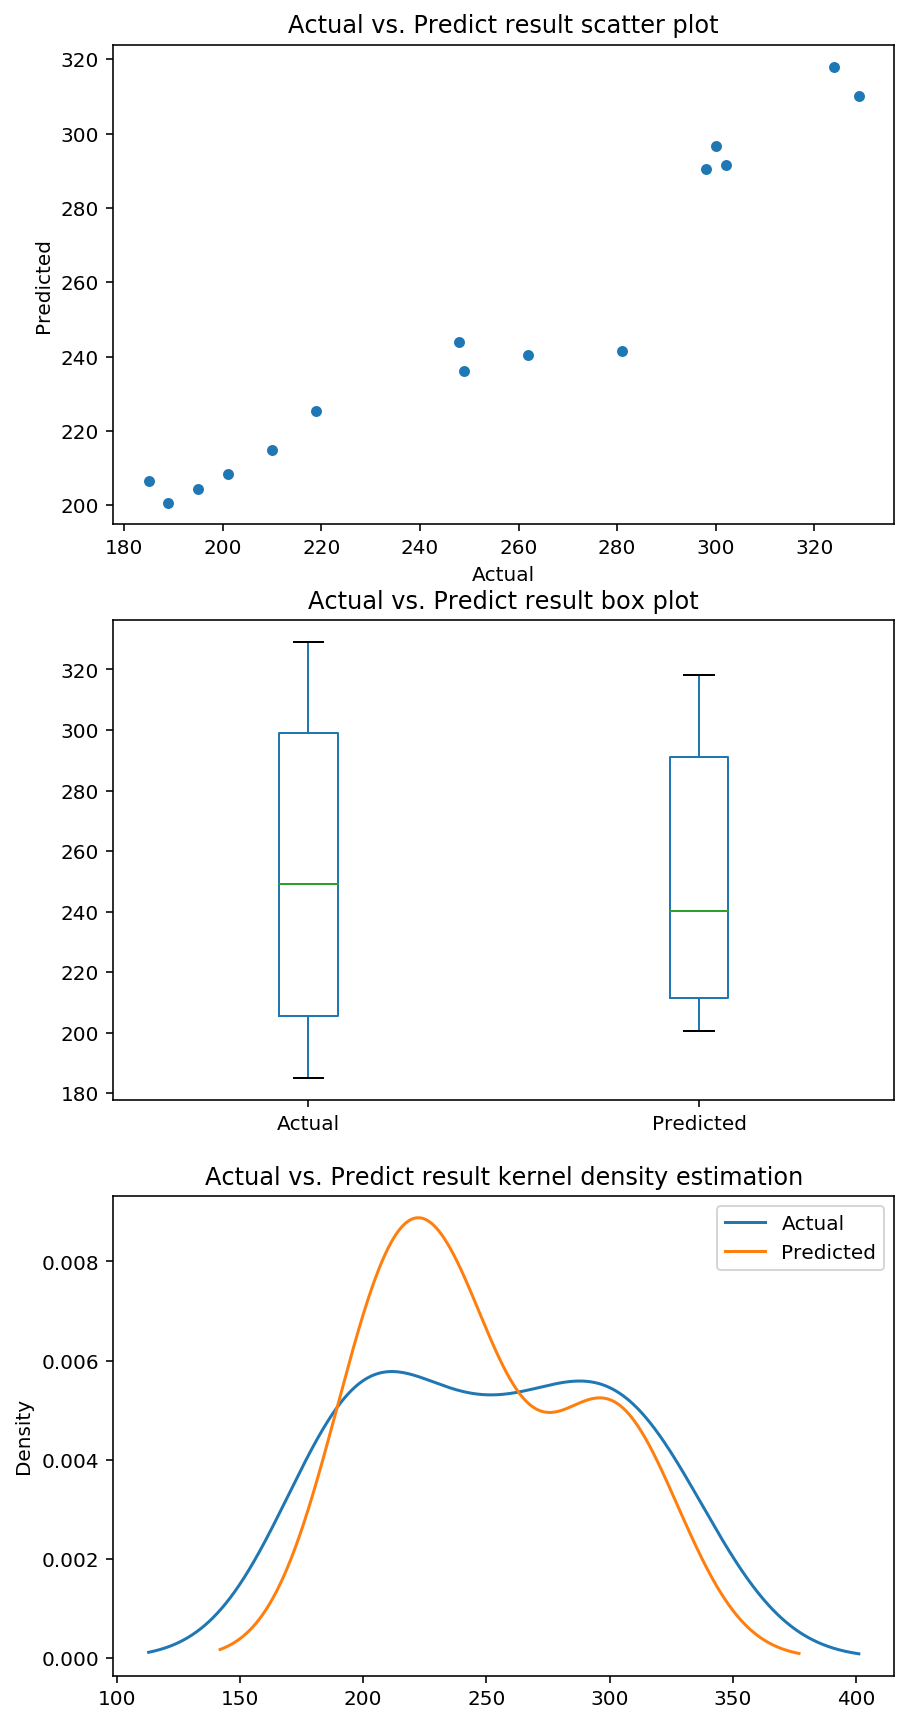

In [69]:
visualize_graph(df_pred_ANN_r)